# GitHub Recommender System
Group members:
- 1795119 - Matteo Orsini
- 1815023 - Fabrizio Rossi

The task we address in this project is to create a recommender system for GitHub repositories, based on the implicit feedback captured when a user stars a repository.

# Colab requirements for PySpark
In this block of code we setup everything needed to run PySpark on Colab.

In [1]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Spark
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# Unzip Spark to the current folder
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

# Set Spark folder in the system path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

# Install findspark and PySpark using pip
!pip install -q findspark
!pip install pyspark

# Set the dataset file paths
users_path = "users.csv"
repos_path = "repos.csv"
starred_path = "starred.csv"

# Setup
In this section, we download the dataset, we import all the libraries used for this project and we setup a Spark instance.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

from IPython.display import HTML

In [3]:
#@title Download dataset from Google Drive
from google_drive_downloader import GoogleDriveDownloader as gdd

datasets = {
  "repos.csv": "13fZqmFP9Nfhu_dk59BJ5hooF3kVsJ39j",
  "starred.csv": "1j_FxOFKVobYBc_wwoVRs9mGLO3cNj5Kc",
  "users.csv": "18IDJA55jM_lo2M4pTTToxcGngdnRPgPO"
}
for name, file_id in datasets.items():
  if not os.path.isfile("/content/" + name):
    gdd.download_file_from_google_drive(file_id=file_id, dest_path="/content/" + name, unzip=False)
  else:
    print(name + " already downloaded.")

repos.csv already downloaded.
starred.csv already downloaded.
users.csv already downloaded.


In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .master("local[*]")
         .appName("GitHub Recommender System")
         .config("spark.ui.port", "4050")
         .config("spark.driver.memory", "10g")
         # Reduce the number of partitions to increase performances in single node mode
         .config("spark.sql.shuffle.partitions", 2) 
         .getOrCreate())

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark.getActiveSession()

## Expose the Spark Web UI

By default PySpark exposes a web interface to manage the current active session on port 4040.
Using a tool called `ngrok` we were able to access it from Colab, in order to monitor the jobs and the resource utilization in a detailed way, which was useful for debugging.

In [5]:
# Change ngrok port to avoid conflicts
!echo "web_addr: 127.0.0.1:4080" > ngrok.yml

In [6]:
# Install ngrok
!wget -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -n ngrok-stable-linux-amd64.zip
get_ipython().system_raw("./ngrok http 4050 -config ./ngrok.yml &")

# Wait that the process starts
import time
time.sleep(2)

# Retrieve Spark UI link
import requests
print("Spark UI link:", requests.get("http://localhost:4080/api/tunnels").json()["tunnels"][0]["public_url"])

File ‘ngrok-stable-linux-amd64.zip’ already there; not retrieving.

Archive:  ngrok-stable-linux-amd64.zip
Spark UI link: https://ac29-35-245-207-167.ngrok.io


# Load Dataset
In this section we load the dataset which is self-collected and contains information about GitHub users and their starred repositories.

## Dataset collection

The collection of the dataset was performed using some custom scripts written in Python. In order to gather the users for our recommender system, we took all the users that starred a very popular repository, [React.js](https://github.com/facebook/react) (a JavaScript library for building user interfaces) and got all the repos starred by those users.

So, we created one script (*users.py*) in order to get all the *stargazers* (the name that GitHub gave to the users that starred a repository) of React. The information of all the stargazers for React is accessible at the link *https://github.com/facebook/react/stargazers*. We obtained and analyzed the HTML of the pages, using the *requests* and *BeautifulSoup* libraries. In this way we were able to write a simple script that goes through several pages and collect the users listed in each page. We decided to collect just 10.000 of all the 170.000 and more users that starred the React repository since the requests takes some time.

Then, after the collection of all the users, we made another script (*stars.py*), which in the same way was used to gather the metadata of all the repositories starred by each user, accessible at the link *https://github.com/user?tab=stars*. We were able to collect more than 1 million relations between users and repos that they starred and a total of 354.981 repositories on GitHub starred by those users.

In order to use the dataset, we need to load it using the methods offered by Spark:

In [7]:
users_df = spark.read.load(users_path, format="csv", sep=",", inferSchema="true", header="true")
repos_df = spark.read.load(repos_path, format="csv", sep=",", inferSchema="true", header="true", quotes='"', escape='"')
starred_df = spark.read.load(starred_path, format="csv", sep=",", inferSchema="true", header="true")

The *users_df* dataframe contains the information relative to all the users of the recommender system, in particular the `user_id` which identifies each user and their `name`.

Instead, the *repos_df* dataframe contains the information relative to all the repositories of the system. Each repository is identified by a `repo_id` and contains several features:
- `creator`: the name of the user or organization that created the repository;
- `name`: the name of the repository;
- `about`: a short description of the content of the repository;
- `language`: the main programming language in which the code in the repository is written;
- `stars`: the number of stars received by the repository;
- `forks`: the number of forks of the repository;
- `updated`: the last time the repository was updated;
- `sponsor`: if the repository can be sponsored or not (a form of donations).

Finally, we have the `starred_df` dataframe which contains the information relative to the repositories that each user has starred, represented as records composed by `user_id` and `repo_id`.

These are some examples of the content of the dataset:



In [8]:
users_df.show(5)
repos_df.show(5)
starred_df.show(5)

+-------+-----------------+
|user_id|             name|
+-------+-----------------+
|      0|EliveltonSouzaDev|
|      1|      Ersonusaini|
|      2|          harixth|
|      3|        Luckyanry|
|      4|       biroltopuz|
+-------+-----------------+
only showing top 5 rows

+-------+-----------------+-----------------+--------------------+----------+------+-----+-------------------+-------+
|repo_id|          creator|             name|               about|  language| stars|forks|            updated|sponsor|
+-------+-----------------+-----------------+--------------------+----------+------+-----+-------------------+-------+
|      0|styled-components|styled-components|Visual primitives...|TypeScript| 33940| 2084|2021-06-16 19:12:26|      0|
|      1|           vercel|          next.js| The React Framework|JavaScript| 69687|13111|2021-06-22 07:49:26|      0|
|      2|         facebook|            react|A declarative, ef...|JavaScript|170264|34406|2021-06-22 06:08:58|      0|
|      3|

# Check Dataset
In this section we inspect the dataset to show some of its characteristics.

In the following block is reported the structure of each dataframe:

In [9]:
users_df.printSchema()
repos_df.printSchema()
starred_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- name: string (nullable = true)

root
 |-- repo_id: integer (nullable = true)
 |-- creator: string (nullable = true)
 |-- name: string (nullable = true)
 |-- about: string (nullable = true)
 |-- language: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- forks: integer (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- sponsor: integer (nullable = true)

root
 |-- user_id: integer (nullable = true)
 |-- repo_id: integer (nullable = true)



## Handle missing values

Let's check if there are missing values in each dataframe:

In [10]:
users_df.select([count(when(col(c).isNull(), c)).alias(c) for c in users_df.columns]).show()
repos_df.select([count(when(col(c).isNull(), c)).alias(c) for c in repos_df.columns]).show()
starred_df.select([count(when(col(c).isNull(), c)).alias(c) for c in starred_df.columns]).show()

+-------+----+
|user_id|name|
+-------+----+
|      0|   0|
+-------+----+

+-------+-------+----+-----+--------+-----+-----+-------+-------+
|repo_id|creator|name|about|language|stars|forks|updated|sponsor|
+-------+-------+----+-----+--------+-----+-----+-------+-------+
|      0|      0|   0|36083|   28039|    0|72874|      0|      0|
+-------+-------+----+-----+--------+-----+-----+-------+-------+

+-------+-------+
|user_id|repo_id|
+-------+-------+
|      0|      0|
+-------+-------+



We can see that there are some records missing the `about`, `language` or `forks` values, so let's analyze those fields:

When the forks value is missing it means that the repo doesn't have any fork. So, we can simply set those values to 0.

In [11]:
repos_df = repos_df.na.fill(0)
repos_df.select([count(when(col(c).isNull(), c)).alias(c) for c in repos_df.columns]).show()

+-------+-------+----+-----+--------+-----+-----+-------+-------+
|repo_id|creator|name|about|language|stars|forks|updated|sponsor|
+-------+-------+----+-----+--------+-----+-----+-------+-------+
|      0|      0|   0|36083|   28039|    0|    0|      0|      0|
+-------+-------+----+-----+--------+-----+-----+-------+-------+



Regarding the language attribute, GitHub will not report the language attribute of a repo when it doesn't know which language was used (maybe the repo doesn't contain any code but just simple text).

Instead, the about attribute will be `null` when the creator of the repo didn't provide any description about the repository.

As a solution, we can create a default value for both: for the language we can create a special class called `UNK`, representing that we don't know the language of the repo; instead, for the about attribute, we can simply assign an empty string to the null values to handle them in the same way as the other ones.

In [12]:
repos_df = repos_df.na.fill("", "about")
repos_df = repos_df.na.fill("UNK", "language")
repos_df.select([count(when(col(c).isNull(), c)).alias(c) for c in repos_df.columns]).show()

+-------+-------+----+-----+--------+-----+-----+-------+-------+
|repo_id|creator|name|about|language|stars|forks|updated|sponsor|
+-------+-------+----+-----+--------+-----+-----+-------+-------+
|      0|      0|   0|    0|       0|    0|    0|      0|      0|
+-------+-------+----+-----+--------+-----+-----+-------+-------+



## Check duplicates

Now we can inspect the dataset in order to check if there are any duplicates.

First of all, let's report the total number of records for each dataframe.

In [13]:
print("Number of records for users.csv:", users_df.count())
print("Number of records for repos.csv:", repos_df.count())
print("Number of records for starred.csv:", starred_df.count())

Number of records for users.csv: 10000
Number of records for repos.csv: 354981
Number of records for starred.csv: 1083195


Now, using the `distinct()` method offered by PySpark we can count the number of distinct values, using the id of each dataframe.

In [14]:
print("Number of distinct records for users.csv:", users_df.select("user_id").distinct().count())
print("Number of distinct records for repos.csv:", repos_df.select("repo_id").distinct().count())
print("Number of distinct records for starred.csv:", starred_df.select("user_id", "repo_id").distinct().count())

Number of distinct records for users.csv: 10000
Number of distinct records for repos.csv: 354981
Number of distinct records for starred.csv: 1083195


As we can see from the results, the values are the same of the total number of records for each dataframe: this means that there are no duplicates.

Moreover, we can also see if we have any duplicated user or repo using their name.

In [15]:
print("Number of distinct names for users.csv:", users_df.select("name").distinct().count())
print("Number of distinct repo name for repos.csv:", repos_df.select("creator", "name").distinct().count())

Number of distinct names for users.csv: 10000
Number of distinct repo name for repos.csv: 354981


But, again, the number of distinct record is the same as the total number of records. This means that all the users and repos have different names, indicating that they are different from each other.

## Describe repos data

In the following block we compute some statistical indicators for some columns of the repos dataframe using the method `describe()`.

In [16]:
repos_df.describe(["stars", "forks", "sponsor"]).show()

+-------+------------------+-----------------+--------------------+
|summary|             stars|            forks|             sponsor|
+-------+------------------+-----------------+--------------------+
|  count|            354981|           354981|              354981|
|   mean|443.86323775075283|98.75728278414901|0.053864854738704324|
| stddev|2337.1390773287194| 807.991949927328|  0.2257511367185888|
|    min|                 0|                0|                   0|
|    max|            325307|           237014|                   1|
+-------+------------------+-----------------+--------------------+



# Exploratory Data Analysis
In this section we dive into the dataset in order to extract some knowledge from it and answer some interesting questions.

## What are the most used programming languages?

In the following plot we show what are the most diffused programming languages according to the number of repos that contain mostly files of that language:

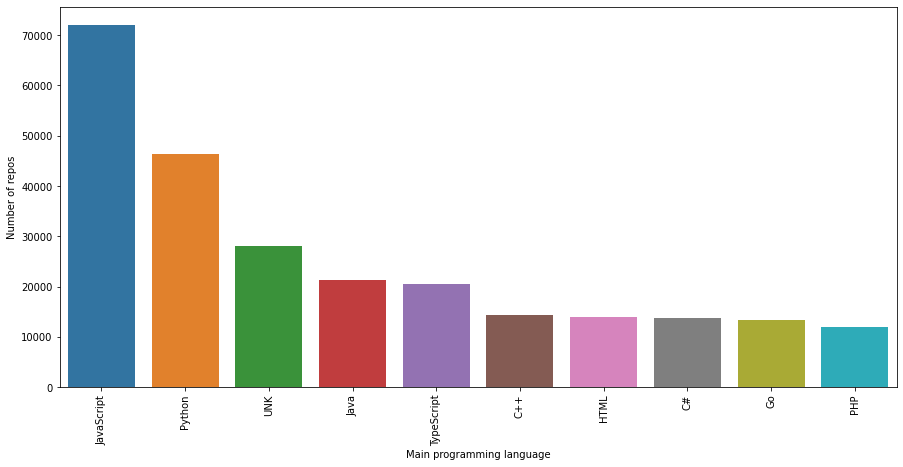

In [17]:
n_languages = 10
plt.figure(figsize=(15, 7))
language_hist = repos_df.toPandas()["language"].value_counts()[:n_languages]
sns.barplot(x=language_hist.index, y=language_hist)
plt.xticks(rotation=90)
plt.xlabel("Main programming language")
plt.ylabel("Number of repos")
plt.show()

As we can see the top 3 used programming languages are:
- Javascript
- Python
- Java

It is not a surprise that Javascript is the most used programming language, since we collected repos starting from the users that starred the React repository, one of the most known Javascript frameworks, so this could have influenced the results.

Interestingly, we can also see that there are a lot of repos that only contain text or use a language not recognized by GitHub (indicated by `UNK`).

## How often are repos updated?

In the following plot we show how frequently repos are updated:

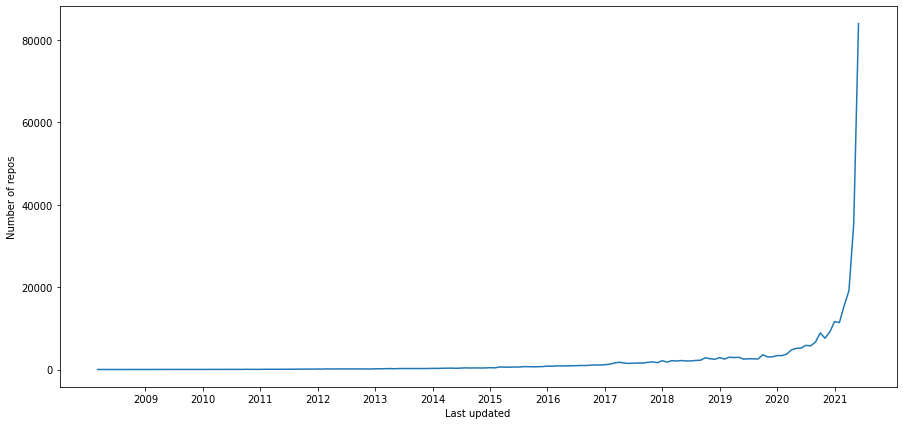

In [18]:
repos_with_month_df = repos_df.withColumn("year", year("updated")).withColumn("month", month("updated"))
number_of_repos_per_month = repos_with_month_df.groupBy("year", "month").count().orderBy("year", "month")

number_of_repos_per_month = number_of_repos_per_month.withColumn("year month", concat(col("year"), lit(" "), col("month")))
data = number_of_repos_per_month.toPandas()

plt.figure(figsize=(15, 7))
sns.lineplot(data=data, x="year month", y="count")
starting_year, starting_month = data.iloc[0]["year"], data.iloc[0]["month"]
ending_year, ending_month = data.iloc[-1]["year"], data.iloc[-1]["month"]

prev_ticks, prev_labels = plt.xticks()

ticks = []
for i in range(0, (ending_year - starting_year) * 12 + 1, 12):
  value = i + (13 - starting_month)
  if value > 0 and value < prev_ticks[-1]:
    ticks.append(value)

plt.xticks(ticks, labels=range(2009, 2022))
plt.xlabel("Last updated")
plt.ylabel("Number of repos")
plt.show()

As we can see the repos we collected are very frequently updated: the majority of them have the last commit made in the last year or two.

## What is the distribution of stars?

In the following plot we show the distribution of stars, meaning how many repos have collected a certain number of stars:

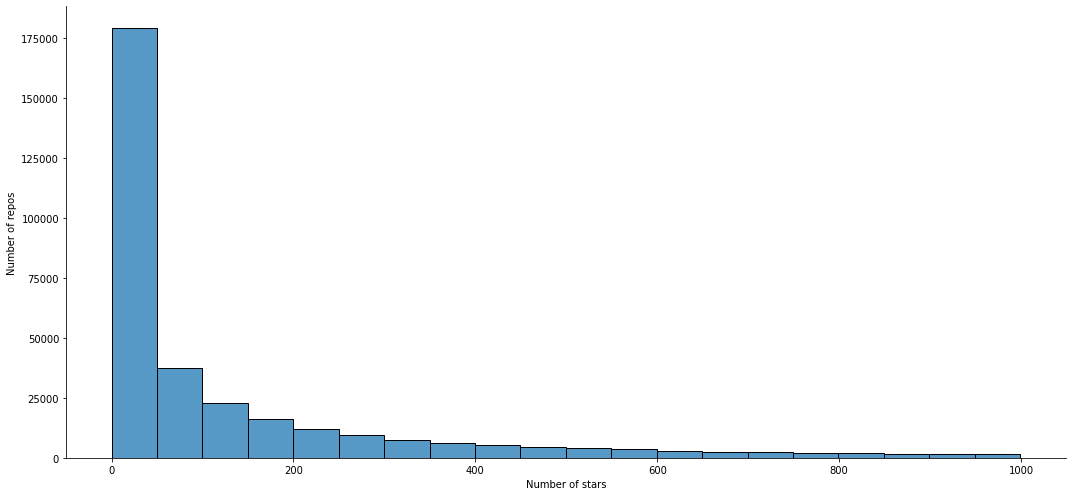

In [19]:
stars_dist = repos_df.toPandas()["stars"]
stars_dist = stars_dist[stars_dist < 1_000]

sns.displot(stars_dist, bins=20, height=7, aspect=15/7)
plt.xlabel("Number of stars")
plt.ylabel("Number of repos")
plt.show()

As we can see, the distribution is really skewed towards the 0, meaning that the majority of the repos have less than 50 stars.

For this reason, we decided to cut the graph to only 1000 stars because, even if there are repos with a higher number of stars, they are very few compared to the ones depicted in the plot.

# Data preparation
In this section we prepare the dataset in order to be processed by our models.

## Dataset pruning
We decided to cut the dataset into a smaller subset of samples, since we don't have enough computational power to handle the whole dataset for all the models.

In fact, to perform some comparisons, we would obtain DataFrames with more than 100 billions of records and unfortunately, neither Colab or Databricks can provide us enough resources to process this amount of data for free.

Let's first see the total size of the dataset before the operation:

In [20]:
print("Old repos count:", repos_df.count())
print("Old users count:", users_df.count())
print("Old starred count:", starred_df.count())

Old repos count: 354981
Old users count: 10000
Old starred count: 1083195


To prune the dataset, we decided to fix the number of users and repositories that we are going to use.

To do so, first of all, we took the most starring users. Then, we took the most starred repositories by those users because they are the elements that can give us more information.

Finally, we removed the user-repo relationships that involved users or repos which were not selected in the previous step.

The final size of our datasets can be seen in the output of the next block.

In [21]:
NEW_USER_COUNT = 1000
NEW_REPOS_COUNT = 1000

most_starring_users = starred_df.groupBy("user_id").count().sort("count", ascending=False).limit(NEW_USER_COUNT).select("user_id")
most_starred_repos = most_starring_users.join(starred_df, "user_id").groupBy("repo_id").count().sort("count", ascending=False).limit(NEW_REPOS_COUNT).select("repo_id")

new_users_df = most_starring_users.join(users_df, "user_id").cache()
new_starred_df = most_starring_users.join(starred_df, "user_id").join(most_starred_repos, "repo_id").cache()
new_repos_df = most_starred_repos.join(repos_df, "repo_id").cache()

print("New repos count:", new_repos_df.count())
print("New users count:", new_users_df.count())
print("New starred count:", new_starred_df.count())

New repos count: 1000
New users count: 1000
New starred count: 104499


## Train/Test split

At this point, we can split the dataset into a training set which is going to be used for setting up our models, and a test set, which is going to be used in order to evaluate their performances.

Moreover, we cache them in order to speed up future computations.

In [22]:
train, test = new_starred_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()
test = test.cache()

# Models
In this section we build the models and we evaluate them computing recommendations for all the users in the pruned dataset.

## Similarities

Many models use a similarity function in order to compare elements and find the most similar ones.

Here we are going to define the functions that we will use in some of them.

### Jaccard Similarity

The Jaccard Index is a similarity measure between two sets and is typically used when you want to find the similarity between two binary vectors.

Given two sets $A$ and $B$, it is computed as follows:

$$
J(A,B) = \frac{A \cap B}{A \cup B}
$$

In [23]:
def jaccard_similarity(array1, array2):
  set1 = set(array1)
  set2 = set(array2)
  return len(set1.intersection(set2)) / len(set1.union(set2))

jaccard_similarity_udf = udf(jaccard_similarity, DoubleType())

### Cosine Similarity

The Cosine similarity is typically used in Information Retrieval to compare how similar are two documents.

Given two vectors $u$ and $v$, the cosine similarity is defined as follows:

$$
\cos(u,v) = \frac{u \cdot v}{||u||_2 ||v||_2}
$$

In [24]:
def cosine_similarity(u, v):
  dot = u.dot(v)
  len = u.norm(2) * v.norm(2)
  if len == 0: return 0.0
  return float(dot / len)

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

In order to compute the personalization metric, we also derived an alternative formulation of the cosine similarity to speed up the computation.

Let's assume we have two binary vectors $u$ and $v$ where the $i$-th component is 1 if the $i$-th element is present, and 0 otherwise.

In our code, those vectors are instead represented as sets by taking only the index of elements that have value 1 in the vector:

$$
A = \{i : u_i = 1 \} \qquad B = \{j : v_j = 1 \}
$$

When we perform the dot product between such vectors, we are going to sum 1 for each element which is in common, and 0 for those that are not, so the result is going to be the number of common elements.

Moreover, the L2-norm of a binary vector is going to simply be the square root of the number of components set to 1.

Given the previous observations, we can re-define in this case the cosine similarity as following:

$$
cos(A, B) = \frac{|A \cap B|}{\sqrt{|A| |B|}}
$$

In [25]:
from math import sqrt

def cosine_similarity_lists(list1, list2):
  set1 = set(list1)
  set2 = set(list2)
  return len(set1.intersection(set2)) / (sqrt(len(set1)) * sqrt(len(set2)))

cosine_similarity_lists_udf = udf(cosine_similarity_lists, DoubleType())

## Evaluation metrics
In order to evaluate our models, we choose to use the following metrics:

#### MAP@K

Mean Average Precision at K (MAP@K) is the mean of the Average Precision at K (AP@K) metric computed for each user. AP@K is a metric commonly used for information retrieval which takes into consideration the precision of the system and the order of the items recommended.

Given that our system returns $K$ repos, where $|Rel|$ are actually relevant, and $1_{Rel}(K)$ is the indicator function that tells us if the $K$-th repo is relevant for a user $u$, AP@N is defined as:

$$
AP@N(u) = \frac{1}{|Rel|} \sum_{K=1}^N P@K(u) \times 1_{Rel}(K)
$$

And so MAP@N, assuming we have $|U|$ users, can be computed as:
$$
MAP@N = \frac{1}{|U|} \sum_{u=1}^{|U|} AP@N(u)
$$

In [26]:
k = 5 #@param {type:"integer"}

In [27]:
from pyspark.ml.evaluation import RankingEvaluator

def map_at_k(recommendations, k):
  evaluator = RankingEvaluator(metricName="meanAveragePrecisionAtK", k=k, predictionCol="recommended_repos", labelCol="labels")
  return evaluator.evaluate(recommendations)

#### Personalization
Personalization is a metric that tells us if the recommender system produces items which are personalized for each user, or if it recommends always the same items to different users.

It is defined as the average of the dissimilarity between users lists of recommendations:
$$
Personalization = 1 - \left( \frac{1}{|U|} \sum_{u_i, u_j \in U \land i < j} cos(u_i, u_j) \right)
$$


In [28]:
def personalization(recommendations):
  target_recommendations = recommendations.withColumnRenamed("user_id", "user2_id").withColumnRenamed("recommended_repos", "target_recommendations")
  cosine_matrix = recommendations.join(target_recommendations, col("user_id") < col("user2_id"))
  cosine_df = cosine_matrix.withColumn("cosine_similarity", cosine_similarity_lists_udf("recommended_repos", "target_recommendations"))
  avg_cos = cosine_df.agg(avg("cosine_similarity").alias("avg_cos")).collect()[0]["avg_cos"]
  return 1 - avg_cos

### Evaluation code

With the following code we compute the MAP@K for $K = 1 ... k$ and the Personalization metric for the dataframe containing the list of repos that the model recommended to each user.

In [29]:
fields = [StructField("Model", StringType(), False)]
fields += [StructField("MAP@" + str(i), DoubleType(), False) for i in range(1, k+1)]
fields += [StructField("Personalization", DoubleType(), False)]
metrics_df = spark.createDataFrame([], StructType(fields))

# Ground truth dataframe
gt = test.withColumn("repo_id", test.repo_id.cast("double")).groupBy("user_id").agg(collect_set("repo_id").alias("labels"))

def evaluate_df(model_name, recommendations, k):
  mapks = [map_at_k(recommendations, _k) for _k in range(1, k+1)]
  p = personalization(recommendations)
  schema = ["Model"] + ["MAP@" + str(i) for i in range(1, k+1)] + ["Personalization"]
  data = [tuple([model_name] + mapks + [p])]
  metrics_df = spark.createDataFrame(data, schema)
  return metrics_df

def round_df(dataframe, decimals, dtypes = ["double", "float"]):
  return dataframe.select([round(col, decimals).alias(col) if dtype in dtypes else col for col, dtype in dataframe.dtypes])

## Content-based filtering

Content-based filtering is a method which uses the features of the items rated by a user in order to find out the items that are similar to those already rated by him.

In [30]:
#@title Settings
VOCAB_SIZE = 1000 #@param
MIN_DOC_FREQ = 10 #@param
N_ITEMS = 5 #@param

### Building Item profiles

The first step for this method, is to construct the item profiles, that are a vectorized representation of each item, in our case, for each repo.

From the features of each repo we removed the `creator` and `name` fields, because they do not add any information to the representation. For the `about` field we used the TF-IDF weighting scheme after a pre-processing phase that cleaned the text. Moreover, we used a one-hot encoding representation for the `language` field and normalized the fields `stars`, `forks` and `updated`. The latter was converted simply as the number of seconds in order to be machine processable. Finally, the `sponsor` field was left as a binary feature.

We start by pre-processing the text in the `about` column.

In [31]:
#@title Text preprocessing functions
from pyspark import StorageLevel

def clean_text(df, column_name):
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    lower_case_df = df.withColumn(column_name, lower(col(column_name)))
    
    trimmed_df = lower_case_df.withColumn(column_name, trim(col(column_name)))
    
    no_punct_df = trimmed_df.withColumn(column_name, regexp_replace(col(column_name), "[^a-zA-Z\\s]", ""))
    
    cleaned_df = no_punct_df.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df)

    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)

    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn(column_name, stemmer_udf("terms"))
    
    return terms_stemmed_df.select(df.columns)

def extract_tfidf_features(df, column_name):
    from pyspark.ml.feature import CountVectorizer, IDF
    from pyspark.ml import Pipeline

    cv = CountVectorizer(inputCol=column_name, outputCol=column_name + "_tf", vocabSize=VOCAB_SIZE, minDF=MIN_DOC_FREQ)
    idf = IDF(inputCol=column_name + "_tf", outputCol=column_name + "_tfidf")

    pipeline = Pipeline(stages=[cv, idf])
    features = pipeline.fit(df)
    tf_idf_features_df = features.transform(df)
    
    result = tf_idf_features_df.withColumn(column_name, col(column_name + "_tfidf"))

    return result.select(df.columns)

In [32]:
features_df = clean_text(new_repos_df, "about")
features_df.show()

+-------+-----------------+--------------------+--------------------+----------+------+-----+-------------------+-------+
|repo_id|          creator|                name|               about|  language| stars|forks|            updated|sponsor|
+-------+-----------------+--------------------+--------------------+----------+------+-----+-------------------+-------+
|      0|styled-components|   styled-components|[visual, primit, ...|TypeScript| 33940| 2084|2021-06-16 19:12:26|      0|
|      1|           vercel|             next.js|  [react, framework]|JavaScript| 69687|13111|2021-06-22 07:49:26|      0|
|      2|         facebook|               react|[declar, effici, ...|JavaScript|170264|34406|2021-06-22 06:08:58|      0|
|      7|        chakra-ui|           chakra-ui|[simpl, modular, ...|TypeScript| 18902| 1527|2021-06-22 07:12:59|      0|
|     11|         yangshun|front-end-intervi...|[nobullshit, answ...|JavaScript| 29404| 4363|2021-06-21 20:00:42|      1|
|     16|     sindresorh

Given the normalized text, we can compute TF-IDF on the same column.

In [33]:
features_df = extract_tfidf_features(features_df, "about")
features_df.show()

+-------+-----------------+--------------------+--------------------+----------+------+-----+-------------------+-------+
|repo_id|          creator|                name|               about|  language| stars|forks|            updated|sponsor|
+-------+-----------------+--------------------+--------------------+----------+------+-----+-------------------+-------+
|      0|styled-components|   styled-components|(132,[10,16,32,33...|TypeScript| 33940| 2084|2021-06-16 19:12:26|      0|
|      1|           vercel|             next.js|(132,[2,4],[2.397...|JavaScript| 69687|13111|2021-06-22 07:49:26|      0|
|      2|         facebook|               react|(132,[1,3,6,123],...|JavaScript|170264|34406|2021-06-22 06:08:58|      0|
|      7|        chakra-ui|           chakra-ui|(132,[4,14,22,29,...|TypeScript| 18902| 1527|2021-06-22 07:12:59|      0|
|     11|         yangshun|front-end-intervi...|(132,[93,127],[4....|JavaScript| 29404| 4363|2021-06-21 20:00:42|      1|
|     16|     sindresorh

In order to convert the `language` field we use the `StringIndexer` to convert 
strings to indexes and then we use the `OneHotEncoder` class to transform the integer representation into one-hot vectors.

In [34]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

cols = features_df.columns

# Convert the language field to indexes
str_indexer = StringIndexer(inputCol="language", outputCol="language_id")
model = str_indexer.fit(features_df)
features_df = model.transform(features_df)

# Use the one-hot encoding on the language field
enc = OneHotEncoder(inputCol="language_id", outputCol="language_cat")
model = enc.fit(features_df)
features_df = model.transform(features_df)

features_df = features_df.withColumn("language", col("language_cat")).select(cols)
features_df.show()

+-------+-----------------+--------------------+--------------------+--------------+------+-----+-------------------+-------+
|repo_id|          creator|                name|               about|      language| stars|forks|            updated|sponsor|
+-------+-----------------+--------------------+--------------------+--------------+------+-----+-------------------+-------+
|      0|styled-components|   styled-components|(132,[10,16,32,33...|(47,[1],[1.0])| 33940| 2084|2021-06-16 19:12:26|      0|
|      1|           vercel|             next.js|(132,[2,4],[2.397...|(47,[0],[1.0])| 69687|13111|2021-06-22 07:49:26|      0|
|      2|         facebook|               react|(132,[1,3,6,123],...|(47,[0],[1.0])|170264|34406|2021-06-22 06:08:58|      0|
|      7|        chakra-ui|           chakra-ui|(132,[4,14,22,29,...|(47,[1],[1.0])| 18902| 1527|2021-06-22 07:12:59|      0|
|     11|         yangshun|front-end-intervi...|(132,[93,127],[4....|(47,[0],[1.0])| 29404| 4363|2021-06-21 20:00:42| 

Then, as we said, we convert the `updated` field in seconds.

In [35]:
features_df = features_df.withColumn("updated", unix_timestamp("updated"))
features_df.show()

+-------+-----------------+--------------------+--------------------+--------------+------+-----+----------+-------+
|repo_id|          creator|                name|               about|      language| stars|forks|   updated|sponsor|
+-------+-----------------+--------------------+--------------------+--------------+------+-----+----------+-------+
|      0|styled-components|   styled-components|(132,[10,16,32,33...|(47,[1],[1.0])| 33940| 2084|1623870746|      0|
|      1|           vercel|             next.js|(132,[2,4],[2.397...|(47,[0],[1.0])| 69687|13111|1624348166|      0|
|      2|         facebook|               react|(132,[1,3,6,123],...|(47,[0],[1.0])|170264|34406|1624342138|      0|
|      7|        chakra-ui|           chakra-ui|(132,[4,14,22,29,...|(47,[1],[1.0])| 18902| 1527|1624345979|      0|
|     11|         yangshun|front-end-intervi...|(132,[93,127],[4....|(47,[0],[1.0])| 29404| 4363|1624305642|      1|
|     16|     sindresorhus|             awesome|(132,[5,21],[2.8

Now, we proceed with the normalization step on the `stars`, `forks`, `updated` and `sponsor` fields.

In [36]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# Aggregate columns for the normalization
va = VectorAssembler(inputCols=["stars", "forks", "updated", "sponsor"], outputCol="repo_info")
item_profiles = va.transform(features_df).select("repo_id", "about", "language", "repo_info")

# Apply MinMax normalization
scaler = MinMaxScaler(inputCol="repo_info", outputCol="scaled_repo_info")
model = scaler.fit(item_profiles)
item_profiles = model.transform(item_profiles)
item_profiles.show()

+-------+--------------------+--------------+--------------------+--------------------+
|repo_id|               about|      language|           repo_info|    scaled_repo_info|
+-------+--------------------+--------------+--------------------+--------------------+
|      0|(132,[10,16,32,33...|(47,[1],[1.0])|[33940.0,2084.0,1...|[0.09672969194187...|
|      1|(132,[2,4],[2.397...|(47,[0],[1.0])|[69687.0,13111.0,...|[0.20754939253307...|
|      2|(132,[1,3,6,123],...|(47,[0],[1.0])|[170264.0,34406.0...|[0.51934934851148...|
|      7|(132,[4,14,22,29,...|(47,[1],[1.0])|[18902.0,1527.0,1...|[0.05011020897854...|
|     11|(132,[93,127],[4....|(47,[0],[1.0])|[29404.0,4363.0,1...|[0.08266758429979...|
|     16|(132,[5,21],[2.83...|(47,[9],[1.0])|[164302.0,20994.0...|[0.50086648127997...|
|     24|(132,[17],[3.1475...|(47,[9],[1.0])|[13234.0,484.0,1....|[0.03253877464976...|
|     28|(132,[0,13],[2.40...|(47,[3],[1.0])|[163490.0,23657.0...|[0.49834919040577...|
|     35|(132,[17,105],[3....|(4

As final step, we aggregate all the features in a single vector using the `VectorAssembler` class.

In [37]:
va = VectorAssembler(inputCols=["about", "language", "scaled_repo_info"], outputCol="item_profile")
item_profiles = va.transform(item_profiles).select("repo_id", "item_profile").persist(StorageLevel.MEMORY_ONLY)
item_profiles.show()

+-------+--------------------+
|repo_id|        item_profile|
+-------+--------------------+
|      0|(183,[10,16,32,33...|
|      1|(183,[2,4,132,179...|
|      2|(183,[1,3,6,123,1...|
|      7|(183,[4,14,22,29,...|
|     11|(183,[93,127,132,...|
|     16|(183,[5,21,141,17...|
|     24|(183,[17,141,179,...|
|     28|(183,[0,13,135,17...|
|     35|(183,[17,105,133,...|
|     43|(183,[0,4,37,50,8...|
|     44|(183,[0,4,37,50,8...|
|     46|(183,[0,2,3,5,9,2...|
|     48|(183,[2,4,6,10,37...|
|     50|(183,[7,8,40,71,1...|
|     53|(183,[0,10,133,17...|
|     58|(183,[1,23,132,17...|
|     64|(183,[0,13,44,55,...|
|     72|(183,[133,179,180...|
|     77|(183,[4,6,10,12,2...|
|     80|(183,[2,6,136,179...|
+-------+--------------------+
only showing top 20 rows



Finally, we can save the item profiles on disk in order to use them later.

In [38]:
item_profiles.write.mode("overwrite").save("content_based-item_profiles.parquet")

### Building User profiles

In this section, we create the user profiles for all the users in the train set, computed as the average of the item profiles that that user has starred.

So, given $\mathcal{I}_u$ which is the set of items vectors starred by user $u$, the user profile of the $i$-th user is defined as:

$$
u = \frac{1}{|\mathcal{I}_u|} \sum_{i \in \mathcal{I}_u} i
$$

To compute them, first of all we add the item profiles to each record of the train set.

In [39]:
repo_item_profiles_df = train.join(item_profiles, on="repo_id")
repo_item_profiles_df.show(truncate=False)

+-------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|repo_id|user_id|item_profile                                                                                                                                                                                                             |
+-------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0      |145    |(183,[10,16,32,33,71,105,133,179,180,181],[2.9967317738870745,3.0801133828261253,3.5765502691400166,3.5075573976530654,4.13616605707544,4.4238481295272205,1.0,0.0967296919418791,0.0235612888024975,0.9793678412424156])|
|0      |322    |(183,[10,16,32,33,71,105,133,179,180,18

Then, we can compute the average of all the item profiles of the repos that each user has starred using the `Summarizer` class.

In [40]:
from pyspark.ml.stat import Summarizer

user_profiles = repo_item_profiles_df.groupBy("user_id").agg(Summarizer.mean(col("item_profile")).alias("user_profile"), collect_set("repo_id").alias("starred_repo")).persist(StorageLevel.MEMORY_ONLY)
user_profiles.show()

+-------+--------------------+--------------------+
|user_id|        user_profile|        starred_repo|
+-------+--------------------+--------------------+
|     90|[0.18249584158976...|[1047, 662, 743, ...|
|    123|[0.28580704682872...|[2440, 7660, 2, 1...|
|    140|[0.20648100934156...|[8604, 204, 662, ...|
|    150|[0.42825690826399...|[1148, 438, 6949,...|
|    191|[0.33226829089447...|[691, 1, 743, 2, ...|
|    210|[0.16728785479062...|[12095, 5199, 259...|
|    263|[0.39276278950841...|[2440, 589, 12907...|
|    320|[0.15055906931155...|[13293, 691, 438,...|
|    336|[0.26766056766499...|[2581, 7692, 2, 1...|
|    369|[0.30111813862311...|[5859, 9409, 1463...|
|    384|[0.25357316936683...|[1148, 8604, 357,...|
|    393|[0.19890372459508...|[7210, 204, 17975...|
|    406|[0.33457570958124...|[3355, 7210, 3682...|
|    419|[0.17130276330559...|[5859, 13061, 146...|
|    426|[0.10107461995741...|[10802, 17402, 60...|
|    431|[0.26279401188926...|[2207, 335, 691, ...|
|    463|[0.

### Predicting new repos

For the prediction, we need to find the $k$ items that are more similar to the user profile for each user, applying the cosine similarity between the user profile vector and the item profile for each item not rated yet.

So, given a user $u$, we compute the similarity values between his user profile and all the items $i$ not rated yet by $u$.

$$
S_u = \{(i, sim(u, i)) : i \in \mathcal{I} - \mathcal{I}_u\}
$$

Then, we **order** the values of $S_u$ based on the similarity value and we get the top-$k$ items.

$$
R_{u,k} = \{S_u[j] : j = 1 ... k \}
$$

In order to put in relation each user profile with all the item profiles we apply the cartesian product between the train set and the item profiles.

In [41]:
user_item_profiles = user_profiles.join(item_profiles)
user_item_profiles.show()

+-------+--------------------+--------------------+-------+--------------------+
|user_id|        user_profile|        starred_repo|repo_id|        item_profile|
+-------+--------------------+--------------------+-------+--------------------+
|     90|[0.18249584158976...|[1047, 662, 743, ...|      0|(183,[10,16,32,33...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|      1|(183,[2,4,132,179...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|      2|(183,[1,3,6,123,1...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|      7|(183,[4,14,22,29,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     11|(183,[93,127,132,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     16|(183,[5,21,141,17...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     24|(183,[17,141,179,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     28|(183,[0,13,135,17...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     35|(183,[17,105,133,...|
|     90|[0.18249584158976..

Before computing the similarity between each item we have to remove the item profiles of the repos already starred by the user, otherwise we will recommend repos that the user has already starred.

In [42]:
user_item_profiles = user_item_profiles.filter(~array_contains(col("starred_repo"), col("repo_id")))
user_item_profiles.show()

+-------+--------------------+--------------------+-------+--------------------+
|user_id|        user_profile|        starred_repo|repo_id|        item_profile|
+-------+--------------------+--------------------+-------+--------------------+
|     90|[0.18249584158976...|[1047, 662, 743, ...|      0|(183,[10,16,32,33...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|      7|(183,[4,14,22,29,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     11|(183,[93,127,132,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     24|(183,[17,141,179,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     28|(183,[0,13,135,17...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     35|(183,[17,105,133,...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     43|(183,[0,4,37,50,8...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     44|(183,[0,4,37,50,8...|
|     90|[0.18249584158976...|[1047, 662, 743, ...|     46|(183,[0,2,3,5,9,2...|
|     90|[0.18249584158976..

Now we can compute the cosine similarity using the previously defined udf functions.

In [43]:
similarity = cosine_similarity_udf("user_profile", "item_profile").alias("similarity")
prediction_df = user_item_profiles.select("user_id", "repo_id", similarity).persist(StorageLevel.MEMORY_ONLY)
prediction_df.show()

+-------+-------+-------------------+
|user_id|repo_id|         similarity|
+-------+-------+-------------------+
|     90|      0|0.19263542812959603|
|     90|      7|0.22949633312015053|
|     90|     11| 0.1631732096607974|
|     90|     24|  0.275482419219751|
|     90|     28| 0.3472998353046473|
|     90|     35|0.21522446037345336|
|     90|     43|0.10339401291029349|
|     90|     44| 0.1156640802140694|
|     90|     46|0.29223742036241324|
|     90|     48| 0.2554083335991793|
|     90|     50|0.25352432546786025|
|     90|     53|0.22718420889810703|
|     90|     58| 0.2433376423737014|
|     90|     64| 0.2472584416780459|
|     90|     72| 0.4332705921803832|
|     90|     77| 0.2510632058887067|
|     90|     80|0.31914765763311753|
|     90|     92| 0.1647830438442851|
|     90|    100|0.20013086943478758|
|     90|    103| 0.1911303884440288|
+-------+-------+-------------------+
only showing top 20 rows



Given the similarities computed in the previous step, we can take the top-k items for each user.

To do that, we use a `Window function` in which we can perform some aggregation operations for subsets of users.

In this case, for each user we order the records by similarity and, after adding the row number for each grouping, we filter them by taking the first `N_ITEMS` records.

In [44]:
from pyspark.sql.window import Window

window_user = Window.partitionBy("user_id").orderBy(col("similarity").desc())
top_k_repos = prediction_df.withColumn("rank", row_number().over(window_user)).filter(col("rank") <= N_ITEMS)
top_k_repos.show()

+-------+-------+-------------------+----+
|user_id|repo_id|         similarity|rank|
+-------+-------+-------------------+----+
|     90|  11903|0.48425226445217956|   1|
|     90|  14274|0.48200720798957775|   2|
|     90|   7854| 0.4806740134282395|   3|
|     90|   8418|  0.480479224263995|   4|
|     90|    619|  0.480397710468917|   5|
|    123|  11903| 0.5193505622041305|   1|
|    123|  14274| 0.5177934184352835|   2|
|    123|    619| 0.5164651457869246|   3|
|    123|   8418| 0.5164383330962349|   4|
|    123|   6355| 0.5157807868617589|   5|
|    140|   5859|0.41908032109972254|   1|
|    140|    716| 0.4092775801854016|   2|
|    140|   2265| 0.4060659936550205|   3|
|    140|   6189|0.40326978334418195|   4|
|    140|   1375| 0.4006986845082195|   5|
|    150|   4672| 0.6085488732632729|   1|
|    150|    418|  0.605380443078601|   2|
|    150|  11903| 0.5802743824972105|   3|
|    150|    643| 0.5768581948324893|   4|
|    150|  14274| 0.5765535234549904|   5|
+-------+--

Now, for the evaluation phase, we can finally aggregate the recommendations for each user in a single vector.

In [45]:
recommendations_list = top_k_repos.withColumn("repo_id", col("repo_id").cast("double")).groupBy("user_id").agg(collect_list("repo_id").alias("recommended_repos"))
recommendations_list.show(truncate=False)

+-------+------------------------------------------+
|user_id|recommended_repos                         |
+-------+------------------------------------------+
|90     |[11903.0, 14274.0, 7854.0, 8418.0, 619.0] |
|123    |[11903.0, 14274.0, 619.0, 8418.0, 6355.0] |
|140    |[5859.0, 716.0, 2265.0, 6189.0, 1375.0]   |
|150    |[4672.0, 418.0, 11903.0, 643.0, 14274.0]  |
|191    |[4672.0, 170.0, 418.0, 6958.0, 438.0]     |
|210    |[11903.0, 1124.0, 8027.0, 14274.0, 7854.0]|
|263    |[4672.0, 418.0, 170.0, 11903.0, 14274.0]  |
|320    |[4672.0, 418.0, 170.0, 526.0, 6958.0]     |
|336    |[141.0, 442.0, 570.0, 17402.0, 80.0]      |
|369    |[72.0, 1254.0, 11903.0, 14274.0, 7854.0]  |
|384    |[5853.0, 16063.0, 431.0, 4672.0, 170.0]   |
|393    |[11903.0, 14274.0, 619.0, 8418.0, 6355.0] |
|406    |[11903.0, 14274.0, 643.0, 7854.0, 619.0]  |
|419    |[11903.0, 14274.0, 8418.0, 619.0, 6355.0] |
|426    |[5880.0, 1254.0, 335.0, 11903.0, 14274.0] |
|431    |[11903.0, 14274.0, 7854.0, 619.0, 841

### Evaluation

In this section, we carry out the evaluation phase for the Content-based filtering model.

In [46]:
recommendations = recommendations_list.join(gt, "user_id").cache()
recommendations.show(truncate=False)

+-------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommended_repos                         |labels                                                                                                                                                                                                                                                                                                                            

In [47]:
evaluation = evaluate_df("Content-Based Filtering", recommendations, k)
metrics_df = metrics_df.union(evaluation)
round_df(evaluation, 3).show(truncate=False)

+-----------------------+-----+-----+-----+-----+-----+---------------+
|Model                  |MAP@1|MAP@2|MAP@3|MAP@4|MAP@5|Personalization|
+-----------------------+-----+-----+-----+-----+-----+---------------+
|Content-Based Filtering|0.067|0.051|0.043|0.037|0.033|0.676          |
+-----------------------+-----+-----+-----+-----+-----+---------------+



### Free resources

In [48]:
item_profiles.unpersist()
user_profiles.unpersist()
prediction_df.unpersist()

# Free RAM
import gc
gc.collect()

717

## User-based CF
In the User-Based Collaborative Filtering technique, we try to recommend new items according to user rating vectors, which in this case are composed by all the IDs corresponding to the repos starred by one user.

In [49]:
#@title Settings
NEIGHBOURS = 5 #@param
N_ITEMS = 5 #@param

### Building Similarity matrix

First of all, we create a dataframe where every row contains a user id and the set of the repos id that the corresponding user has starred:

In [50]:
starred_repos = train.groupBy("user_id").agg(collect_set("repo_id").alias("starred_repos"))
starred_repos.show()

+-------+--------------------+
|user_id|       starred_repos|
+-------+--------------------+
|     90|[1047, 662, 743, ...|
|    123|[2440, 7660, 2, 1...|
|    140|[8604, 204, 662, ...|
|    150|[1148, 438, 6949,...|
|    191|[691, 1, 743, 2, ...|
|    210|[12095, 5199, 259...|
|    263|[2440, 589, 12907...|
|    320|[13293, 691, 438,...|
|    336|[2581, 7692, 2, 1...|
|    369|[5859, 9409, 1463...|
|    384|[1148, 8604, 357,...|
|    393|[7210, 204, 17975...|
|    406|[3355, 7210, 3682...|
|    419|[5859, 13061, 146...|
|    426|[10802, 17402, 60...|
|    431|[2207, 335, 691, ...|
|    463|[25974, 169, 2, 1...|
|    483|[5859, 1395, 2, 6...|
|    499|[2258, 6977, 1057...|
|    546|[2599, 691, 4081,...|
+-------+--------------------+
only showing top 20 rows



Then, we compute the Jaccard similarity between each user pair using their vectors:

In [51]:
source_users = starred_repos.withColumnRenamed("user_id", "source_user_id").withColumnRenamed("starred_repos", "source_starred_repos")
target_users = starred_repos.withColumnRenamed("user_id", "target_user_id").withColumnRenamed("starred_repos", "target_starred_repos")
users_join = source_users.join(target_users, source_users.source_user_id != target_users.target_user_id)
jaccard = users_join.withColumn("jaccard_similarity", jaccard_similarity_udf("source_starred_repos", "target_starred_repos"))
jaccard.show()

+--------------+--------------------+--------------+--------------------+--------------------+
|source_user_id|source_starred_repos|target_user_id|target_starred_repos|  jaccard_similarity|
+--------------+--------------------+--------------+--------------------+--------------------+
|            90|[1047, 662, 743, ...|           123|[2440, 7660, 2, 1...| 0.07758620689655173|
|            90|[1047, 662, 743, ...|           140|[8604, 204, 662, ...|                0.01|
|            90|[1047, 662, 743, ...|           150|[1148, 438, 6949,...|0.027777777777777776|
|            90|[1047, 662, 743, ...|           191|[691, 1, 743, 2, ...| 0.09195402298850575|
|            90|[1047, 662, 743, ...|           210|[12095, 5199, 259...| 0.05343511450381679|
|            90|[1047, 662, 743, ...|           263|[2440, 589, 12907...|  0.0896551724137931|
|            90|[1047, 662, 743, ...|           320|[13293, 691, 438,...|0.031578947368421054|
|            90|[1047, 662, 743, ...|           33

### Taking top k similar users
Now we need to take the top-$k$ most similar users for each user.

They are formally computed as follows, using the similarity matrix previously built:

$$
\mathcal{U}^k = argmax_{\mathcal{U}' \subseteq \mathcal{U} / u, |\mathcal{U}'| = k} \sum_{u' \in \mathcal{U}'} sim(u, u')
$$

In our case, we take the `NEIGHBOURS` most similar users to each user in the dataframe to later use their starred repos:

In [52]:
window = Window.partitionBy(jaccard["source_user_id"]).orderBy(jaccard["jaccard_similarity"].desc())
most_similar_users = (jaccard.select("*", row_number().over(window).alias("rank"))
  .filter(col("rank") <= NEIGHBOURS))
most_similar_users.show()

+--------------+--------------------+--------------+--------------------+-------------------+----+
|source_user_id|source_starred_repos|target_user_id|target_starred_repos| jaccard_similarity|rank|
+--------------+--------------------+--------------+--------------------+-------------------+----+
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|           0.203125|   1|
|            90|[1047, 662, 743, ...|          7579|[6977, 691, 865, ...|0.15463917525773196|   2|
|            90|[1047, 662, 743, ...|          9864|[743, 1853, 2, 11...|0.13690476190476192|   3|
|            90|[1047, 662, 743, ...|           550|[1984, 1853, 2, 7...|0.13513513513513514|   4|
|            90|[1047, 662, 743, ...|          5027|[743, 1853, 2, 71...|0.13131313131313133|   5|
|           123|[2440, 7660, 2, 1...|          6932|[5859, 743, 2, 12...|0.16363636363636364|   1|
|           123|[2440, 7660, 2, 1...|          1257|[489, 2, 125, 418...|0.12389380530973451|   2|
|         

### Predicting new repos

Identified the users neighbours, we can compute the predictions taking the items rated by the user's neighbours.

$$
\mathcal{I}^k = \{ i \in \mathcal{I} : r_{u,i} = (defined) \land u \in \mathcal{U}^k\}
$$


So, we take all the repos starred by the most similar users and we remove the repos already starred by the source user:

In [53]:
possible_repos = most_similar_users.select("*", explode("target_starred_repos").alias("starred_repo"))
repos_without_source_repos = possible_repos.filter(~array_contains(col("source_starred_repos"), col("starred_repo")))
repos_without_source_repos.show()

+--------------+--------------------+--------------+--------------------+------------------+----+------------+
|source_user_id|source_starred_repos|target_user_id|target_starred_repos|jaccard_similarity|rank|starred_repo|
+--------------+--------------------+--------------+--------------------+------------------+----+------------+
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|         204|
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|        1984|
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|        1853|
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|        5861|
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|        2180|
|            90|[1047, 662, 743, ...|          4885|[204, 1984, 743, ...|          0.203125|   1|        5680|
|

Now, we aggregate the neighbours ratings using the plain average between the ratings.

$$
r_{u,i} = \frac{1}{k} \sum_{v \in \mathcal{U}^k} r_{v,i}
$$

where $r_{v,i}$ is the rating already given by the user $v$ to the item $i$.

In our case, we don't have proper integer ratings but just a binary implicit feedback, given by the fact that a user starred a repo or not. So, we can change the aggregation formula to simplify the process in this scenario.

First of all, since we only care about the relative order of the items and not the exact value, we can omit the normalization factor, i.e. $\frac{1}{k}$. Moreover, the rating for each user can be 1 or 0, so we can simply count the number of users that starred that item to obtain the sum of the ratings.

So, we compute the score of each repo starred by one of the top-$k$ most similar users, by computing how many times the repo has been starred by them:

In [54]:
repos_occurrencies = repos_without_source_repos.groupBy("source_user_id", "starred_repo").count()
repos_occurrencies.show()

+--------------+------------+-----+
|source_user_id|starred_repo|count|
+--------------+------------+-----+
|            90|         204|    1|
|            90|        1984|    3|
|            90|        1853|    4|
|            90|        5861|    1|
|            90|        2180|    1|
|            90|        5680|    2|
|            90|         483|    3|
|            90|        1826|    1|
|            90|        1339|    3|
|            90|        4258|    2|
|            90|         433|    1|
|            90|        1899|    1|
|            90|         527|    2|
|            90|         100|    1|
|            90|         398|    1|
|            90|        6532|    2|
|            90|        9351|    2|
|            90|         706|    1|
|            90|          46|    1|
|            90|       10107|    1|
+--------------+------------+-----+
only showing top 20 rows



Then, we take the `N_ITEMS` top scoring repos using the usual Window function:

In [55]:
window = Window.partitionBy(repos_occurrencies["source_user_id"]).orderBy(repos_occurrencies["count"].desc())
recommendations = (repos_occurrencies.select("*", row_number().over(window).alias("rank")) 
  .filter(col("rank") <= N_ITEMS))
recommendations.show()

+--------------+------------+-----+----+
|source_user_id|starred_repo|count|rank|
+--------------+------------+-----+----+
|            90|        1853|    4|   1|
|            90|        1984|    3|   2|
|            90|         483|    3|   3|
|            90|        1339|    3|   4|
|            90|       15729|    3|   5|
|           123|         238|    4|   1|
|           123|         482|    4|   2|
|           123|         122|    3|   3|
|           123|          16|    3|   4|
|           123|         120|    3|   5|
|           140|         424|    5|   1|
|           140|          28|    4|   2|
|           140|           2|    3|   3|
|           140|         746|    3|   4|
|           140|        2162|    3|   5|
|           150|         192|    3|   1|
|           150|         120|    3|   2|
|           150|        3375|    3|   3|
|           150|        2609|    3|   4|
|           150|        8937|    3|   5|
+--------------+------------+-----+----+
only showing top

Finally, we compute the set of repos recommended by the model for each user:

In [56]:
recommendations_list = (recommendations
                        .withColumn("starred_repo", col("starred_repo")
                        .cast("double")).groupBy("source_user_id")
                        .agg(collect_list("starred_repo").alias("recommended_repos")))
recommendations_list.show()

+--------------+--------------------+
|source_user_id|   recommended_repos|
+--------------+--------------------+
|            90|[1853.0, 1984.0, ...|
|           123|[238.0, 482.0, 12...|
|           140|[424.0, 28.0, 2.0...|
|           150|[192.0, 120.0, 33...|
|           191|[35.0, 1148.0, 13...|
|           210|[2400.0, 204.0, 5...|
|           263|[1839.0, 5144.0, ...|
|           320|[35.0, 1070.0, 11...|
|           336|[526.0, 7959.0, 6...|
|           369|[7567.0, 10544.0,...|
|           384|[1110.0, 441.0, 5...|
|           393|[16.0, 2361.0, 54...|
|           406|[833.0, 11844.0, ...|
|           419|[352.0, 1995.0, 6...|
|           426|[238.0, 28.0, 357...|
|           431|[489.0, 2.0, 527....|
|           463|[647.0, 4394.0, 2...|
|           483|[192.0, 11469.0, ...|
|           499|[6005.0, 458.0, 5...|
|           546|[2.0, 158.0, 7.0,...|
+--------------+--------------------+
only showing top 20 rows



### Evaluation

In this section, we carry out the evaluation phase for the User-based Collaborative Filtering model.

In [57]:
recommendations = recommendations_list.withColumnRenamed("source_user_id", "user_id").join(gt, "user_id").cache()
recommendations.show()

+-------+--------------------+--------------------+
|user_id|   recommended_repos|              labels|
+-------+--------------------+--------------------+
|     90|[1853.0, 1984.0, ...|[1258.0, 5968.0, ...|
|    123|[238.0, 482.0, 12...|[238.0, 123.0, 10...|
|    140|[424.0, 28.0, 2.0...|[4815.0, 2.0, 296...|
|    150|[192.0, 120.0, 33...|[2162.0, 8332.0, ...|
|    191|[35.0, 1148.0, 13...|[383.0, 414.0, 35...|
|    210|[2400.0, 204.0, 5...|[238.0, 3374.0, 7...|
|    263|[1839.0, 5144.0, ...|[11903.0, 988.0, ...|
|    320|[35.0, 1070.0, 11...|[1236.0, 6935.0, ...|
|    336|[526.0, 7959.0, 6...|     [2851.0, 357.0]|
|    369|[7567.0, 10544.0,...|[7197.0, 2967.0, ...|
|    384|[1110.0, 441.0, 5...|[527.0, 11.0, 106...|
|    393|[16.0, 2361.0, 54...|[383.0, 645.0, 49...|
|    406|[833.0, 11844.0, ...|[2162.0, 35.0, 11...|
|    419|[352.0, 1995.0, 6...|[6251.0, 10136.0,...|
|    426|[238.0, 28.0, 357...|[383.0, 1342.0, 1...|
|    431|[489.0, 2.0, 527....|[669.0, 4140.0, 7...|
|    463|[64

In [58]:
evaluation = evaluate_df("User-Based Collaborative Filtering", recommendations, k)
metrics_df = metrics_df.union(evaluation)
round_df(evaluation, 3).show(truncate=False)

+----------------------------------+-----+-----+-----+-----+-----+---------------+
|Model                             |MAP@1|MAP@2|MAP@3|MAP@4|MAP@5|Personalization|
+----------------------------------+-----+-----+-----+-----+-----+---------------+
|User-Based Collaborative Filtering|0.357|0.261|0.213|0.183|0.164|0.965          |
+----------------------------------+-----+-----+-----+-----+-----+---------------+



### Free resources

In [59]:
# Free RAM
import gc
gc.collect()

4150

## Item-based CF

In the Item-based Collaborative Filtering technique, we try to recommend new items exploiting the similarity between the vector representation of the items that a user has already starred and the ones that has not starred yet.


In [60]:
#@title Settings
NEIGHBOURS =  5#@param
N_ITEMS =  5#@param

### Compute Similarity

In order to build the similarity matrix, we compute the item vectors which are the lists of users that starred that repo.

In [61]:
item_vectors = train.groupBy("repo_id").agg(collect_set("user_id").alias("item_vector"))
item_vectors.show()

+-------+--------------------+
|repo_id|         item_vector|
+-------+--------------------+
|      2|[8951, 9380, 8982...|
|     28|[9380, 785, 3450,...|
|     46|[1199, 5147, 7202...|
|     50|[3601, 6164, 2543...|
|     58|[7681, 8343, 6471...|
|     77|[5147, 7202, 2992...|
|     92|[6164, 4995, 6287...|
|    109|[5534, 4416, 6623...|
|    110|[5359, 4995, 7681...|
|    118|[6956, 2665, 9380...|
|    123|[8748, 1657, 9765...|
|    126|[2992, 7275, 5534...|
|    133|[5359, 7914, 9634...|
|    168|[8951, 9634, 8751...|
|    169|[8951, 7202, 1657...|
|    176|[4995, 4110, 2992...|
|    187|[5990, 7994, 9634...|
|    198|[7202, 9380, 785,...|
|    202|[785, 5432, 9411,...|
|    203|[9380, 5534, 8343...|
+-------+--------------------+
only showing top 20 rows



Then, we add the item vectors to each repo in the train set.

In [62]:
user_item = train.join(item_vectors, "repo_id")
user_item.show()

+-------+-------+--------------------+
|repo_id|user_id|         item_vector|
+-------+-------+--------------------+
|      0|    145|[5990, 2665, 1657...|
|      0|    322|[5990, 2665, 1657...|
|      0|    726|[5990, 2665, 1657...|
|      0|    746|[5990, 2665, 1657...|
|      0|    766|[5990, 2665, 1657...|
|      0|    971|[5990, 2665, 1657...|
|      0|   1567|[5990, 2665, 1657...|
|      0|   1638|[5990, 2665, 1657...|
|      0|   1657|[5990, 2665, 1657...|
|      0|   1977|[5990, 2665, 1657...|
|      0|   2011|[5990, 2665, 1657...|
|      0|   2061|[5990, 2665, 1657...|
|      0|   2126|[5990, 2665, 1657...|
|      0|   2226|[5990, 2665, 1657...|
|      0|   2464|[5990, 2665, 1657...|
|      0|   2517|[5990, 2665, 1657...|
|      0|   2665|[5990, 2665, 1657...|
|      0|   2911|[5990, 2665, 1657...|
|      0|   2931|[5990, 2665, 1657...|
|      0|   3108|[5990, 2665, 1657...|
+-------+-------+--------------------+
only showing top 20 rows



Now, in order to add the list of starred repos to each user record of the train set, we take all the repos starred by each user.

$$
\mathcal{I}_u = \{ i \in \mathcal{I} : r_{u,i} = (defined) \}
$$

In [63]:
user_starred_repos = train.groupBy("user_id").agg(collect_set("repo_id").alias("starred_repos"))
user_starred_repos.show()

+-------+--------------------+
|user_id|       starred_repos|
+-------+--------------------+
|     90|[1047, 662, 743, ...|
|    123|[2440, 7660, 2, 1...|
|    140|[8604, 204, 662, ...|
|    150|[1148, 438, 6949,...|
|    191|[691, 1, 743, 2, ...|
|    210|[12095, 5199, 259...|
|    263|[2440, 589, 12907...|
|    320|[13293, 691, 438,...|
|    336|[2581, 7692, 2, 1...|
|    369|[5859, 9409, 1463...|
|    384|[1148, 8604, 357,...|
|    393|[7210, 204, 17975...|
|    406|[3355, 7210, 3682...|
|    419|[5859, 13061, 146...|
|    426|[10802, 17402, 60...|
|    431|[2207, 335, 691, ...|
|    463|[25974, 169, 2, 1...|
|    483|[5859, 1395, 2, 6...|
|    499|[2258, 6977, 1057...|
|    546|[2599, 691, 4081,...|
+-------+--------------------+
only showing top 20 rows



Then, we can finally add the starred repos to each record user-item.

In [64]:
user_item = user_item.join(user_starred_repos, "user_id")
user_item.show()

+-------+-------+--------------------+--------------------+
|user_id|repo_id|         item_vector|       starred_repos|
+-------+-------+--------------------+--------------------+
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|
|    322|      0|[5990, 2665, 1657...|[0, 1322, 4081, 7...|
|    726|      0|[5990, 2665, 1657...|[0, 17402, 4059, ...|
|    746|      0|[5990, 2665, 1657...|[10802, 0, 743, 1...|
|    766|      0|[5990, 2665, 1657...|[0, 5859, 17975, ...|
|    971|      0|[5990, 2665, 1657...|[0, 4379, 16, 179...|
|   1567|      0|[5990, 2665, 1657...|[0, 8603, 8798, 3...|
|   1638|      0|[5990, 2665, 1657...|[2207, 0, 17975, ...|
|   1657|      0|[5990, 2665, 1657...|[0, 6977, 13061, ...|
|   1977|      0|[5990, 2665, 1657...|[1148, 0, 458, 21...|
|   2011|      0|[5990, 2665, 1657...|[6316, 4393, 407,...|
|   2061|      0|[5990, 2665, 1657...|[0, 14672, 757, 3...|
|   2126|      0|[5990, 2665, 1657...|[2440, 0, 510, 74...|
|   2226|      0|[5990, 2665, 1657...|[0

Now, we associate the items on which will be computed the similarity value. We need to put in relation all the items starred by the user $u$ with all the items not starred yet by $u$.

$$
S_u = \{ (i, i') : i \in I_u \land i' \in I - I_u \}
$$

In practice, we join the items starred by each user with all the item vectors. Notice that it is important to remove the items already starred by the user, i.e. $i \in I_u$ and to do so we can use the list of starred repos added before.

In [65]:
other_items = item_vectors.select(col("repo_id").alias("no_starred_repo_id"), col("item_vector").alias("no_starred_item_vector"))
user_item_item = user_item.join(other_items, ~array_contains(col("starred_repos"), col("no_starred_repo_id")))
user_item_item.show()

+-------+-------+--------------------+--------------------+------------------+----------------------+
|user_id|repo_id|         item_vector|       starred_repos|no_starred_repo_id|no_starred_item_vector|
+-------+-------+--------------------+--------------------+------------------+----------------------+
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|                50|  [3601, 6164, 2543...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|                58|  [7681, 8343, 6471...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|                77|  [5147, 7202, 2992...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|                92|  [6164, 4995, 6287...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|               109|  [5534, 4416, 6623...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|               110|  [5359, 4995, 7681...|
|    145|      0|[5990, 2665, 1657...|[0, 133, 489, 2, ...|               118|  [6

Since we will have many correlations item-to-item repeated for different users, we precompute the similarity matrix among all the pairs of items simply computing the Jaccard similarity.

In [66]:
temp = item_vectors.select(col("repo_id").alias("no_starred_repo_id"), col("item_vector").alias("no_starred_item_vector"))
similarity = item_vectors.join(temp, col("repo_id") != col("no_starred_repo_id"))

similarity = similarity.withColumn("jaccard_similarity", jaccard_similarity_udf("item_vector", "no_starred_item_vector"))
similarity.show()

+-------+--------------------+------------------+----------------------+--------------------+
|repo_id|         item_vector|no_starred_repo_id|no_starred_item_vector|  jaccard_similarity|
+-------+--------------------+------------------+----------------------+--------------------+
|      2|[8951, 9380, 8982...|                28|  [9380, 785, 3450,...|  0.2503128911138924|
|      2|[8951, 9380, 8982...|                46|  [1199, 5147, 7202...| 0.11637347767253045|
|      2|[8951, 9380, 8982...|                50|  [3601, 6164, 2543...|0.036885245901639344|
|      2|[8951, 9380, 8982...|                58|  [7681, 8343, 6471...| 0.05327868852459016|
|      2|[8951, 9380, 8982...|                77|  [5147, 7202, 2992...| 0.15013054830287206|
|      2|[8951, 9380, 8982...|                92|  [6164, 4995, 6287...|0.059474412171507604|
|      2|[8951, 9380, 8982...|               109|  [5534, 4416, 6623...| 0.12234042553191489|
|      2|[8951, 9380, 8982...|               110|  [5359, 49

As said, we use the previous matrix in order to compute the similarity between all the repos for each user.

In [67]:
from pyspark.sql.functions import broadcast

similarity_matrix = similarity.select(col("repo_id").alias("sim_repo_id"), col("no_starred_repo_id").alias("sim_no_starred_repo_id"), "jaccard_similarity")
jaccard = user_item_item.join(broadcast(similarity_matrix), [col("repo_id") == col("sim_repo_id"), col("no_starred_repo_id") == col("sim_no_starred_repo_id")])
jaccard = jaccard.select("user_id", "repo_id", "no_starred_repo_id", "jaccard_similarity")
jaccard.show()

+-------+-------+------------------+--------------------+
|user_id|repo_id|no_starred_repo_id|  jaccard_similarity|
+-------+-------+------------------+--------------------+
|    145|      0|                50| 0.04316546762589928|
|    145|      0|                58|0.060810810810810814|
|    145|      0|                77| 0.12658227848101267|
|    145|      0|                92|  0.0410958904109589|
|    145|      0|               109| 0.07476635514018691|
|    145|      0|               110| 0.07006369426751592|
|    145|      0|               118| 0.06521739130434782|
|    145|      0|               168| 0.11398963730569948|
|    145|      0|               169|  0.1377245508982036|
|    145|      0|               176|0.044444444444444446|
|    145|      0|               187| 0.06923076923076923|
|    145|      0|               198| 0.07553956834532374|
|    145|      0|               202|                0.04|
|    145|      0|               203| 0.03355704697986577|
|    145|     

### Taking top k similar items

Now, in order to predict the score for a given item $i$ we compute the top-$k$ similar items starred by $u$ to the item $i$.

$$
\mathcal{I}_u^k = argmax_{\mathcal{I}_u' \subseteq \mathcal{I}_u, |\mathcal{I}_u'| = k} \sum_{i' \in \mathcal{I}_u'} sim(i, i')
$$

In [68]:
window = Window.partitionBy(jaccard["user_id"], jaccard["no_starred_repo_id"]).orderBy(jaccard["jaccard_similarity"].desc())
top_k_repos = jaccard.select("*", row_number().over(window).alias("rank")).filter(col("rank") <= NEIGHBOURS)
top_k_repos.show()

+-------+-------+------------------+-------------------+----+
|user_id|repo_id|no_starred_repo_id| jaccard_similarity|rank|
+-------+-------+------------------+-------------------+----+
|     44|   1510|                 0|               0.12|   1|
|     44|    442|                 0|0.11764705882352941|   2|
|     44|      2|                 0|0.09878213802435724|   3|
|     44|    526|                 0|0.09293680297397769|   4|
|     44|    615|                 0| 0.0712166172106825|   5|
|     44|    528|                11|0.14906832298136646|   1|
|     44|    526|                11|0.13877551020408163|   2|
|     44|    879|                11| 0.1349206349206349|   3|
|     44|   1609|                11| 0.1044776119402985|   4|
|     44|    442|                11| 0.0946969696969697|   5|
|     44|      2|                16|0.25660377358490566|   1|
|     44|    442|                16|0.20638820638820637|   2|
|     44|    615|                16|0.20175438596491227|   3|
|     44

### Predicting new repos

At this point, we need to aggregate the scores of the $k$ items found, but a plain average will not work in our case: the only rating that can appear for the items rated by the user $u$ is 1, since we are considering a simple binary implicit feedback. So, we used the average using the similarity as defined below.

$$
r_{u,i} = \frac{\sum_{i' \in \mathcal{I}_u^k} sim(i, i')}{k}
$$

where $k$ is the number of neighbours we are considering.


In [69]:
repo_scores = top_k_repos.groupBy("user_id", "no_starred_repo_id").agg(mean("jaccard_similarity").alias("score"))
repo_scores.show()

+-------+------------------+-------------------+
|user_id|no_starred_repo_id|              score|
+-------+------------------+-------------------+
|     44|                 0|0.10011652340650937|
|     44|                11|0.12438780994867024|
|     44|                16| 0.2018375631754771|
|     44|                24|0.11022950936767298|
|     44|                28| 0.1818073826917406|
|     44|                44|0.07396391035965834|
|     44|                64|0.15888102394160838|
|     44|                77|0.14432752748636773|
|     44|                92|0.08991605503664538|
|     44|               100|0.13464067031674037|
|     44|               103|0.12287995864638199|
|     44|               105| 0.0559815800324021|
|     44|               109|0.14219041528150095|
|     44|               110|0.12495900305493532|
|     44|               117|0.16565828738226474|
|     44|               118|0.18089617314022183|
|     44|               119|0.20520966941343274|
|     44|           

And take the top-k items for each user based on the previously computed score.

In [70]:
window = Window.partitionBy(repo_scores["user_id"]).orderBy(repo_scores["score"].desc())
recommendations = repo_scores.select("*", row_number().over(window).alias("rank")).filter(col("rank") <= N_ITEMS)
recommendations.show()

+-------+------------------+-------------------+----+
|user_id|no_starred_repo_id|              score|rank|
+-------+------------------+-------------------+----+
|     90|                35| 0.2661138474702245|   1|
|     90|               721|0.25232144871625534|   2|
|     90|               238| 0.2500617220006752|   3|
|     90|               666|0.24981770825868094|   4|
|     90|                28|0.24801501995847888|   5|
|    123|               238|0.26438959561139347|   1|
|    123|                 1|0.25163484181731915|   2|
|    123|               398|0.24390532800978665|   3|
|    123|               120|0.23142484587209666|   4|
|    123|               476|0.22800927165819615|   5|
|    140|                 2|0.21983671799856802|   1|
|    140|                 1| 0.2163965637884247|   2|
|    140|              1110|0.21459631995431208|   3|
|    140|               721|0.21189484222334082|   4|
|    140|               674| 0.2068299357223093|   5|
|    150|                35|

Finally, we construct the list of repos recommended for each user.

In [71]:
recommendations_list = recommendations.withColumn("no_starred_repo_id", col("no_starred_repo_id").cast("double")).groupBy("user_id").agg(collect_list("no_starred_repo_id").alias("recommended_repos"))
recommendations_list.show()

+-------+--------------------+
|user_id|   recommended_repos|
+-------+--------------------+
|     90|[35.0, 721.0, 238...|
|    123|[238.0, 1.0, 398....|
|    140|[2.0, 1.0, 1110.0...|
|    150|[35.0, 238.0, 1.0...|
|    191|[35.0, 352.0, 198...|
|    210|[238.0, 1.0, 527....|
|    263|[35.0, 28.0, 1110...|
|    320|[35.0, 119.0, 1.0...|
|    336|[1.0, 35.0, 16.0,...|
|    369|[1110.0, 198.0, 6...|
|    384|[527.0, 1110.0, 3...|
|    393|[35.0, 16.0, 238....|
|    406|[1110.0, 721.0, 5...|
|    419|[28.0, 1.0, 527.0...|
|    426|[238.0, 1.0, 120....|
|    431|[2.0, 120.0, 35.0...|
|    463|[8687.0, 35.0, 35...|
|    483|[35.0, 238.0, 674...|
|    499|[16.0, 666.0, 28....|
|    546|[2.0, 35.0, 238.0...|
+-------+--------------------+
only showing top 20 rows



### Evaluation

In this section, we carry out the evaluation phase for the Item-based Collaborative Filtering model.

In [72]:
recommendations = recommendations_list.join(gt, "user_id").cache()
recommendations.show(truncate=False)

+-------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommended_repos                    |labels                                                                                                                                                                                                                                                                                                                                      

In [73]:
evaluation = evaluate_df("Item-Based Collaborative Filtering", recommendations, k)
metrics_df = metrics_df.union(evaluation)
round_df(evaluation, 3).show(truncate=False)

+----------------------------------+-----+-----+-----+-----+-----+---------------+
|Model                             |MAP@1|MAP@2|MAP@3|MAP@4|MAP@5|Personalization|
+----------------------------------+-----+-----+-----+-----+-----+---------------+
|Item-Based Collaborative Filtering|0.388|0.308|0.263|0.229|0.205|0.68           |
+----------------------------------+-----+-----+-----+-----+-----+---------------+



### Free resources

In [74]:
import gc
gc.collect()

491

## Matrix Factorization

In the Matrix Factorization technique, we try to estimate the ranking matrix as a product of two other matrices, the users and items matrices, which both have a lower rank than the starting matrix and can be learned from the observed ratings.

Those matrices contain latent factors and a single prediction is made by computing the dot product between a user vector $x_u$ and an item vector $w_i$.

$$
r_{u,i} = x^T_u \cdot w_i = \sum_{j=0}^d x_{u,j} w_{j, i}
$$

where $d$ is the dimension of the latent space.

So, in order to obtain the recommended repos for a user $u$ we have to build the matrix $R \in \mathbb{R}_{m \times n}$ which is given by the matrix multiplication between the user vectors matrix $X \in \mathbb{R}_{m \times d}$ and the item vectors matrix $W \in \mathbb{R}_{d \times n}$ transposed.

$$
R = X \times W^T
$$

This time, the model is already implemented in the PySpark library, so less code is required.

In [75]:
#@title Settings
N_ITEMS = 5 #@param

### Training

The $R$ matrix is partially known from the training set and so, the model takes in input all the previous ratings from all the users. In order to do this, we need to build the entire user-item matrix $M$ as follows:

$$
m_{ij} = \begin{cases}
1 & \text{if } r_{i,j} = (defined) \\
0 & \text{otherwise}
\end{cases}
$$

In order to produce the predictions, we build a test set, which will contain all the user-repo pairs such that the user has not starred the repo.

$$
TEST = \{ (u, i) : u \in \mathcal{U} \land i \in \mathcal{I} \land r_{u,i} \neq (defined) \}
$$

In [76]:
from pyspark import StorageLevel

non_starred_train_df = new_repos_df.select("repo_id").join(new_users_df.select("user_id")).exceptAll(train)
non_starred_train_df = non_starred_train_df.persist(StorageLevel.MEMORY_ONLY)
train_matrix = train.withColumn("starred", lit(1)).union(non_starred_train_df.withColumn("starred", lit(0)))
train_matrix = train_matrix.persist(StorageLevel.MEMORY_ONLY)
train_matrix.show()

+-------+-------+-------+
|repo_id|user_id|starred|
+-------+-------+-------+
|      0|    145|      1|
|      0|    322|      1|
|      0|    726|      1|
|      0|    746|      1|
|      0|    766|      1|
|      0|    971|      1|
|      0|   1567|      1|
|      0|   1638|      1|
|      0|   1657|      1|
|      0|   1977|      1|
|      0|   2011|      1|
|      0|   2061|      1|
|      0|   2126|      1|
|      0|   2226|      1|
|      0|   2464|      1|
|      0|   2517|      1|
|      0|   2665|      1|
|      0|   2911|      1|
|      0|   2931|      1|
|      0|   3108|      1|
+-------+-------+-------+
only showing top 20 rows



In order to compute the $R$ matrix we set up an optimization problem based on the following loss function.

$$
L(X, W) = \sum_{(u,i) \in TRAIN} (m_{u,i} - x_u^T \cdot w_i)^2 + \text{regularization}
$$

So, we want to minimize the distance between the known ratings in the matrix $M$, and the predicted ratings, given by the dot product between the two matrices.

$$
X^*, W^* = argmin_{X, W} L(X,W)
$$

Now, we can address this optimization problem in several ways. The method used by PySpark is the **Alternating Least Squares (ALS)**.

The ALS method is based on the idea to fix one latent matrix and compute the optimal for the other one, then we swap the two roles and update the other matrix.

Let's now set the parameters of the model, which have been tuned using manual experiments, and train it:

In [77]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

train_with_ratings = train.withColumn("starred", lit(1))

als_params = {
    "rank": 5,
    "maxIter": 20, 
    "userCol": "user_id", 
    "itemCol": "repo_id", 
    "ratingCol": "starred", 
    "coldStartStrategy": "drop",
    "seed": 42,
    "regParam": 0.1,
    "implicitPrefs": True,
    "nonnegative": False,
    "alpha": 1
}
als = ALS(**als_params)
als_model = als.fit(train_matrix)

Here is a discussion about the parameter tuning we carried out:
  - `rank` is the rank of the two matrices. We tried both to increase and decrease this number, but the lower it is and the less accurate results we get, while if we increase it, we don't achieve higher scores.
  - `maxIter` is the maximum number of iterations which is performed to compute the matrices.
  - `coldStartStrategy` this is to indicate that we should drop records for new users not seen in the training. It is used to perform a correct evaluation.
  - `regParam` is the regularization parameter. We tried 0.001, 0.01, 0.1 and 1, and 0.1 worked best.
  - `implicitPrefs` indicates that we use implicit preferences meaning that they are not ratings but an evidence on how "strong" is the observation. This also uses some tweaks in the implementations to obtain better results in our case.
  - `nonnegative` indicates if some non negative constraints are added to the optimization problem. Since we only need to rank items, we saw that disabling this achieved better performances.
  - `alpha` indicates how confident we are in the rating. In our case we know for sure that a user starred a repo, so we left it at 1, even if we experimented with lower values, obtaining worse results.

We also save the model to use it later in the demo:

In [78]:
als_model.write().overwrite().save("als_model")

### Prediction

We can now obtain the recommendations from our model by predicting a score for each non-starred repo for each user:

In [79]:
predict = als_model.transform(non_starred_train_df).cache()
predict.show()

+-------+-------+----------+
|repo_id|user_id|prediction|
+-------+-------+----------+
|      2|    140|0.23797423|
|      2|    431|0.47488958|
|      2|    546|0.26229107|
|      2|    586|0.61152077|
|      2|    656|0.38166583|
|      2|    723|0.38425478|
|      2|    744| 1.1301888|
|      2|    823|0.58897686|
|      2|    835|0.71540534|
|      2|    850| 0.2564758|
|      2|    947|0.61876297|
|      2|   1041| 0.5520584|
|      2|   1065|0.44424093|
|      2|   1069| 1.2033892|
|      2|   1104|0.49694663|
|      2|   1171| 1.1404679|
|      2|   1262| 0.6350749|
|      2|   1277|0.23192126|
|      2|   1329|0.44869748|
|      2|   1359|0.39930958|
+-------+-------+----------+
only showing top 20 rows



Let's now take the `N_ITEMS` top scoring repos for each user:

In [80]:
window = Window.partitionBy(predict["user_id"]).orderBy(predict["prediction"].desc())
top_k_items = (predict.select("*", row_number().over(window).alias("rank")) 
  .filter(col("rank") <= N_ITEMS))
top_k_items.show()

+-------+-------+----------+----+
|repo_id|user_id|prediction|rank|
+-------+-------+----------+----+
|     35|     90| 0.4050569|   1|
|    320|     90|0.38768515|   2|
|    666|     90| 0.3849909|   3|
|    527|     90|0.36306375|   4|
|      7|     90|0.35994244|   5|
|      1|    123| 0.4360758|   1|
|    398|    123|0.43481076|   2|
|    120|    123|0.41536427|   3|
|    238|    123|0.40301564|   4|
|     48|    123| 0.3501742|   5|
|      2|    140|0.23797423|   1|
|    482|    140| 0.1968115|   2|
|   1110|    140|0.18946297|   3|
|     16|    140|0.18742013|   4|
|    721|    140|0.18241842|   5|
|     35|    150|0.44719887|   1|
|    160|    150|0.41495872|   2|
|    398|    150| 0.3903003|   3|
|    120|    150| 0.3847297|   4|
|    615|    150| 0.3797544|   5|
+-------+-------+----------+----+
only showing top 20 rows



### Evaluation

Finally, we convert the dataframe to a format suitable for the evaluation:

In [81]:
recommendations = top_k_items.withColumn("repo_id", col("repo_id").cast("double")).groupBy("user_id").agg(collect_list("repo_id").alias("recommended_repos"))
recommendations = recommendations.join(gt, "user_id").cache()
recommendations.show(truncate=False)

+-------+---------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommended_repos                      |labels                                                                                                                                                                                                                                                                                                                                  

In [82]:
evaluation = evaluate_df("Matrix Factorization", recommendations, k)
metrics_df = metrics_df.union(evaluation)
round_df(evaluation, 3).show(truncate=False)

+--------------------+-----+-----+-----+-----+-----+---------------+
|Model               |MAP@1|MAP@2|MAP@3|MAP@4|MAP@5|Personalization|
+--------------------+-----+-----+-----+-----+-----+---------------+
|Matrix Factorization|0.506|0.393|0.332|0.298|0.268|0.864          |
+--------------------+-----+-----+-----+-----+-----+---------------+



### Free resources

In [83]:
non_starred_train_df.unpersist()
train_matrix.unpersist()

DataFrame[repo_id: int, user_id: int, starred: int]

## Models comparison

Let's now show the metrics collected by all the models in order to compare them:

In [84]:
round_df(metrics_df, 3).show(truncate=False)

+----------------------------------+-----+-----+-----+-----+-----+---------------+
|Model                             |MAP@1|MAP@2|MAP@3|MAP@4|MAP@5|Personalization|
+----------------------------------+-----+-----+-----+-----+-----+---------------+
|Content-Based Filtering           |0.067|0.051|0.043|0.037|0.033|0.676          |
|User-Based Collaborative Filtering|0.357|0.261|0.213|0.183|0.164|0.965          |
|Item-Based Collaborative Filtering|0.388|0.308|0.263|0.229|0.205|0.68           |
|Matrix Factorization              |0.506|0.393|0.332|0.298|0.268|0.864          |
+----------------------------------+-----+-----+-----+-----+-----+---------------+



As we can see from the comparative table above, the best performing model according to MAP@K is the **Matrix Factorization**, while the worst one is the **Content-Based Filtering**, probably due to the low discriminance of the repos features we extracted. In particular, the about field, which should give us more information than other fields, in general is very short and contains recurring terms which means we will obtain similar TF-IDF vectors for different repos but with similar descriptions.

The User and Item based approaches instead obtain similar performances from the point of view of MAP@K, but while the Item-based obtains a slightly higher MAP@K in general, the User-based approach obtains a higher Personalization score, which moreover is the best of all.

From the table we can see that the scores obtained for the MAP@K decrease with the increase of $K$. This was an expected behaviour, since using a higher $K$ means we have more chances to recommend a non-interesting repository.

# Demo

In this section we setup a working demo, including a web server, which allows to experiment with all the recommender systems from a web interface.

For each model we also include an example of what results it produces using the same user/repos.

## Models definitions

First we define a base class for each model, which can be used to predict repos for both an already existing user, indicated by his id, or a new user represented by the repos he has starred.

In [85]:
class RecommenderModel():

  def __init__(self, users_df, repos_df, starred_repos_df):
    self.users = users_df
    self.repos = repos_df
    self.starred_repos = starred_repos_df

  def predict_from_user(user_id):
    pass

  def predict_from_repos(starred_repos_list):
    pass

### Content-based

In [86]:
from pyspark.ml.stat import Summarizer

class ContentBased(RecommenderModel):

  def __init__(self, users_df, repos_df, starred_repos_df):
    super().__init__(users_df, repos_df, starred_repos_df)
    # Load the item profiles previously saved in the notebook
    self.item_profiles = spark.read.load("content_based-item_profiles.parquet")

  def predict_from_user_profile(self, user_profile, K):
    # Perform a cartesian product between the user profile and all the item profiles
    user_item_profiles = user_profile.join(self.item_profiles)

    # Remove the repos already starred by the user
    user_item_profiles = user_item_profiles.filter(~array_contains(col("starred_repo"), col("repo_id")))

    # Compute the similarity between the user profile and each item profile
    similarity = cosine_similarity_udf("user_profile", "item_profile").alias("score")
    prediction_df = user_item_profiles.select("repo_id", similarity)

    # Take the top-k items
    top_k_repos = prediction_df.orderBy(col("score").desc()).limit(K)

    return top_k_repos

  def predict_from_user(self, user_id, K):
    # Get the item profiles of the repos starred by the user
    join_df = train.filter(col("user_id") == user_id).join(self.item_profiles, on="repo_id")

    # Compute the user profile as the mean of the item profiles of the starred repos
    user_profile = join_df.groupBy("user_id").agg(Summarizer.mean(col("item_profile")).alias("user_profile"), collect_set("repo_id").alias("starred_repo"))

    return self.predict_from_user_profile(user_profile, K)

  def predict_from_repos(self, starred_repos_list, K):
    # Take all the item profiles of the repos starred
    starred_items_profiles = self.item_profiles.filter(col("repo_id").isin(starred_repos_list))

    # Compute the user profile as the mean of the item profiles of the starred repos
    user_profile = starred_items_profiles.agg(Summarizer.mean(col("item_profile")).alias("user_profile"), collect_set("repo_id").alias("starred_repo"))

    return self.predict_from_user_profile(user_profile, K)

cbm = ContentBased(new_users_df, new_repos_df, train)

In [87]:
#@title Predict from user id
user_id = 463 #@param {type: "integer"}
n_items = 5 #@param {type: "integer"}
recommendations = cbm.predict_from_user(user_id, n_items)

display(HTML("<h3>Repos previously starred by user " + str(user_id) + "</h3>"))
display(train.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas())

display(HTML("<br /><h3>Predicted repos for user " + str(user_id) + "</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

display(HTML("<br /><h3>Ground Truth for user " + str(user_id) + "</h3>"))
test.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas()

,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,2,463,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
1,169,463,date-fns,date-fns,⏳ Modern JavaScript date utility library ⌛️,JavaScript,26155,1260,2021-06-21 12:37:46,0
2,13629,463,square,okhttp,"Square’s meticulous HTTP client for the JVM, A...",Java,40244,8538,2021-06-14 08:10:00,0
3,25974,463,square,retrofit,A type-safe HTTP client for Android and the JVM,Java,38265,6872,2021-06-24 19:20:04,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
4,8815,0.669058,request,request,🏊🏾 Simplified HTTP request client.,JavaScript,25189,3062,2021-05-20 12:36:23,0
2,1583,0.480193,signalapp,Signal-Android,A private messenger for Android.,Java,20775,4982,2021-06-22 00:27:46,0
1,473,0.479396,qbittorrent,qBittorrent,qBittorrent BitTorrent client,C++,12288,2201,2021-06-22 05:15:45,0
3,5922,0.479263,go-redis,redis,Type-safe Redis client for Golang,Go,11762,1498,2021-06-21 06:45:54,0
0,160,0.472465,axios,axios,Promise based HTTP client for the browser and ...,JavaScript,85310,8327,2021-06-22 05:55:53,0


,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,120,463,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
1,204,463,django,django,The Web framework for perfectionists with dead...,Python,58081,24842,2021-06-22 08:28:44,1
2,961,463,bumptech,glide,An image loading and caching library for Andro...,Java,31342,5710,2021-06-11 23:50:48,0
3,1279,463,ReactiveX,rxjs,A reactive programming library for JavaScript,TypeScript,25031,2575,2021-06-21 19:24:28,0
4,1369,463,r-spacex,SpaceX-API,"🚀 Open Source REST API for SpaceX launch, rock...",JavaScript,8548,686,2021-06-19 16:04:27,0
5,2045,463,DrKLO,Telegram,Telegram for Android source,C++,17143,5993,2021-06-03 05:06:31,0
6,8254,463,google,gson,A Java serialization/deserialization library t...,Java,19688,3818,2021-06-19 12:39:51,0
7,9684,463,jquense,yup,Dead simple Object schema validation,TypeScript,13746,616,2021-06-21 18:30:52,0


In [88]:
#@title Predict from repos id
repos_id = [1, 5, 6, 8] #@param {type:"raw"}
n_items = 5 #@param {type: "integer"}
recommendations = cbm.predict_from_repos(repos_id, n_items)

display(HTML("<h3>Repos previously starred</h3>"))
display(new_repos_df.filter(col("repo_id").isin(repos_id)).toPandas())

display(HTML("<br /><h3>Predicted repos</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

,repo_id,creator,name,about,language,stars,forks,updated,sponsor
0,1,vercel,next.js,The React Framework,JavaScript,69687,13111,2021-06-22 07:49:26,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
1,1143,0.798809,ReactTraining,react-router,Declarative routing for React,JavaScript,43426,8466,2021-06-15 22:38:05,0
2,2393,0.784845,alibaba,ice,🚀 The Progressive Framework Based On React（基于 ...,TypeScript,16379,1951,2021-06-17 09:38:33,0
4,15532,0.743813,umijs,umi,🌋 Pluggable enterprise-level react application...,TypeScript,10697,1687,2021-06-25 06:53:08,0
3,7977,0.718425,react-dnd,react-dnd,Drag and Drop for React,TypeScript,15992,1668,2021-06-17 17:20:10,0
0,553,0.718241,pmndrs,react-three-fiber,🇨🇭 A React renderer for Three.js,TypeScript,13725,728,2021-06-19 12:17:17,0


### User-based CF

In [89]:
class UserBasedCF(RecommenderModel):

  def predict_from_user(self, user_id, K, neighbours = 5):
    # Compute the starred repos by each user
    starred_repos_set = self.starred_repos.groupBy("user_id").agg(collect_set("repo_id").alias("starred_repos"))

    user_starred_repos = starred_repos_set.filter(col("user_id") == user_id)
    target_starred_repos = starred_repos_set.withColumnRenamed("starred_repos", "target_starred_repos").withColumnRenamed("user_id", "target_user_id")

    # Prepare to compare the user rating vector with any other user
    users_comparisons = user_starred_repos.join(target_starred_repos, col("user_id") != col("target_user_id"))

    return self.predict(users_comparisons, K, neighbours)

  def predict_from_repos(self, starred_repos_list, K, neighbours = 5):
    # Create a Dataframe with the starred repos
    user_starred_repos = spark.createDataFrame([(starred_repos_list, )], ["starred_repos"])

    target_starred_repos = self.starred_repos.groupBy("user_id").agg(collect_set("repo_id").alias("target_starred_repos"))
    # Prepare to compare the user rating vector with any other user
    users_comparisons = user_starred_repos.join(target_starred_repos)
    return self.predict(users_comparisons, K, neighbours)

  def predict(self, users_comparisons, K, neighbours = 5):
    # Compute the Jaccard similarity among the repos starred by the user and those starred by any other user
    jaccard = users_comparisons.withColumn("jaccard_similarity", jaccard_similarity_udf("starred_repos", "target_starred_repos"))

    # Compute the `neighbours` most similar users
    top_k_users = jaccard.sort("jaccard_similarity", ascending=False).limit(neighbours)
    
    # Remove the repos already starred
    possible_repos = top_k_users.select("*", explode("target_starred_repos").alias("repo_id"))
    repos_without_source_repos = possible_repos.filter(~array_contains(col("starred_repos"), col("repo_id")))

    # Compute how many times each repo has been starred by other users
    repos_occurrencies = repos_without_source_repos.groupBy("repo_id").count()

    # Compute the k most starred repos
    recommendations = repos_occurrencies.sort("count", ascending=False).limit(K)
    # Normalize the count dividing by k to obtain a score
    recommendations = recommendations.withColumn("score", col("count") / neighbours).drop("count")

    return recommendations

ubm = UserBasedCF(new_users_df, new_repos_df, train)

In [90]:
#@title Predict from user id
user_id = 463 #@param {type: "integer"}
n_items = 5 #@param {type: "integer"}
neighbours = 5 #@param {type: "integer"}
recommendations = ubm.predict_from_user(user_id, n_items, neighbours)

display(HTML("<h3>Repos previously starred by user " + str(user_id) + "</h3>"))
display(train.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas())

display(HTML("<br /><h3>Predicted repos for user " + str(user_id) + "</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

display(HTML("<br /><h3>Ground Truth for user " + str(user_id) + "</h3>"))
test.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas()

,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,2,463,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
1,169,463,date-fns,date-fns,⏳ Modern JavaScript date utility library ⌛️,JavaScript,26155,1260,2021-06-21 12:37:46,0
2,13629,463,square,okhttp,"Square’s meticulous HTTP client for the JVM, A...",Java,40244,8538,2021-06-14 08:10:00,0
3,25974,463,square,retrofit,A type-safe HTTP client for Android and the JVM,Java,38265,6872,2021-06-24 19:20:04,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
0,647,0.2,justjavac,free-programming-books-zh_CN,📚 免费的计算机编程类中文书籍，欢迎投稿,UNK,80728,23574,2021-05-25 00:52:10,0
1,2042,0.2,iluwatar,java-design-patterns,Design patterns implemented in Java,Java,68497,21345,2021-06-22 05:03:56,1
2,4394,0.2,zxing,zxing,"ZXing (""Zebra Crossing"") barcode scanning libr...",Java,27934,9025,2021-06-07 12:11:10,0
3,5956,0.2,MrRio,jsPDF,Client-side JavaScript PDF generation for ever...,JavaScript,22230,4027,2021-06-18 08:42:15,0
4,21661,0.2,bilibili,ijkplayer,"Android/iOS video player based on FFmpeg n3.4,...",C,29014,7524,2021-06-13 14:34:08,0


,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,120,463,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
1,204,463,django,django,The Web framework for perfectionists with dead...,Python,58081,24842,2021-06-22 08:28:44,1
2,961,463,bumptech,glide,An image loading and caching library for Andro...,Java,31342,5710,2021-06-11 23:50:48,0
3,1279,463,ReactiveX,rxjs,A reactive programming library for JavaScript,TypeScript,25031,2575,2021-06-21 19:24:28,0
4,1369,463,r-spacex,SpaceX-API,"🚀 Open Source REST API for SpaceX launch, rock...",JavaScript,8548,686,2021-06-19 16:04:27,0
5,2045,463,DrKLO,Telegram,Telegram for Android source,C++,17143,5993,2021-06-03 05:06:31,0
6,8254,463,google,gson,A Java serialization/deserialization library t...,Java,19688,3818,2021-06-19 12:39:51,0
7,9684,463,jquense,yup,Dead simple Object schema validation,TypeScript,13746,616,2021-06-21 18:30:52,0


In [91]:
#@title Predict from repos id
repos_id = [1, 5, 6, 8] #@param {type:"raw"}
n_items = 5 #@param {type: "integer"}
neighbours = 5 #@param {type: "integer"}
recommendations = ubm.predict_from_repos(repos_id, n_items, neighbours)

display(HTML("<h3>Repos previously starred</h3>"))
display(new_repos_df.filter(col("repo_id").isin(repos_id)).toPandas())

display(HTML("<br /><h3>Predicted repos</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

,repo_id,creator,name,about,language,stars,forks,updated,sponsor
0,1,vercel,next.js,The React Framework,JavaScript,69687,13111,2021-06-22 07:49:26,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
0,2,1.0,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
3,119,0.6,denoland,deno,A secure JavaScript and TypeScript runtime,Rust,76219,4010,2021-06-22 07:18:01,1
2,103,0.4,enaqx,awesome-react,A collection of awesome things regarding React...,UNK,44028,5314,2021-06-21 08:30:17,0
1,48,0.2,facebook,react-native,A framework for building native apps with React.,JavaScript,96207,20943,2021-06-22 06:00:50,0
4,1320,0.2,Semantic-Org,Semantic-UI,Semantic is a UI component framework based aro...,JavaScript,49338,5128,2021-04-18 15:16:46,0


### Item-based CF

In [92]:
from pyspark.sql.functions import broadcast

class ItemBasedCF(RecommenderModel):

  def __init__(self, users_df, repos_df, starred_df):
    super().__init__(users_df, repos_df, starred_df)

    # Compute the item vector (list of users that starred that repo) for each repo
    self.item_vectors = self.starred_repos.groupBy("repo_id").agg(collect_set("user_id").alias("item_vector"))

  def predict_from_user(self, user_id, K, neighbours = 5):
    # Add the item vectors info to the starred repos
    user_items = self.starred_repos.filter(col("user_id") == user_id).join(self.item_vectors, "repo_id")
    
    # Add the starred repos array to each record
    user_starred_repos = self.starred_repos.filter(col("user_id") == user_id).groupBy("user_id").agg(collect_set("repo_id").alias("starred_repos"))
    user_items = user_items.join(user_starred_repos, "user_id")
    
    # Remove all the items that the user has already starred
    other_items = self.item_vectors.select(col("repo_id").alias("no_starred_repo_id"), col("item_vector").alias("no_starred_item_vector"))
    user_item_item = user_items.join(other_items, ~array_contains(col("starred_repos"), col("no_starred_repo_id")))

    # Compute the similarity of each pair of repos
    jaccard = user_item_item.withColumn("jaccard_similarity", jaccard_similarity_udf("item_vector", "no_starred_item_vector")).select("repo_id", "no_starred_repo_id", "jaccard_similarity")

    # Select the top `neighbours` based on the similarity
    window = Window.partitionBy(jaccard["no_starred_repo_id"]).orderBy(jaccard["jaccard_similarity"].desc())
    top_k_repos = jaccard.select("*", row_number().over(window).alias("rank")).filter(col("rank") <= neighbours)

    # Aggregate the repos we found
    repo_scores = top_k_repos.groupBy("no_starred_repo_id").agg(mean("jaccard_similarity").alias("score"))

    # Compute the top-k repos
    recommendations = repo_scores.sort("score", ascending=False).limit(K).withColumnRenamed("no_starred_repo_id", "repo_id")

    return recommendations

  def predict_from_repos(self, starred_repos_list, K, neighbours = 5):
    # Add the item vectors info to the starred repos
    user_items = self.item_vectors.filter(col("repo_id").isin(starred_repos_list))

    # Add the starred repos array to each record
    user_starred_repos = array([lit(repo_id) for repo_id in starred_repos_list])
    user_items = user_items.withColumn("starred_repos", user_starred_repos)

    # Remove all the items that the user has already starred
    other_items = self.item_vectors.select(col("repo_id").alias("no_starred_repo_id"), col("item_vector").alias("no_starred_item_vector"))
    user_item_item = user_items.join(other_items, ~array_contains(col("starred_repos"), col("no_starred_repo_id")))

    # Compute the similarity of each pair of repos
    jaccard = user_item_item.withColumn("jaccard_similarity", jaccard_similarity_udf("item_vector", "no_starred_item_vector")).select("repo_id", "no_starred_repo_id", "jaccard_similarity")

    # Select the top `neighbours` based on the similarity
    window = Window.partitionBy(jaccard["no_starred_repo_id"]).orderBy(jaccard["jaccard_similarity"].desc())
    top_k_repos = jaccard.select("*", row_number().over(window).alias("rank")).filter(col("rank") <= neighbours)

    # Aggregate the repos we found
    repo_scores = top_k_repos.groupBy("no_starred_repo_id").agg(mean("jaccard_similarity").alias("score"))

    # Compute the top-k repos
    recommendations = repo_scores.sort("score", ascending=False).limit(K).withColumnRenamed("no_starred_repo_id", "repo_id")

    return recommendations

ibm = ItemBasedCF(new_users_df, new_repos_df, train)

In [93]:
#@title Predict from user id
user_id = 463 #@param {type: "integer"}
n_items = 5 #@param {type: "integer"}
neighbours = 5 #@param {type: "integer"}
recommendations = ibm.predict_from_user(user_id, n_items, neighbours)

display(HTML("<h3>Repos previously starred by user " + str(user_id) + "</h3>"))
display(train.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas())

display(HTML("<br /><h3>Predicted repos for user " + str(user_id) + "</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

display(HTML("<br /><h3>Ground Truth for user " + str(user_id) + "</h3>"))
test.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas()

,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,2,463,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
1,169,463,date-fns,date-fns,⏳ Modern JavaScript date utility library ⌛️,JavaScript,26155,1260,2021-06-21 12:37:46,0
2,13629,463,square,okhttp,"Square’s meticulous HTTP client for the JVM, A...",Java,40244,8538,2021-06-14 08:10:00,0
3,25974,463,square,retrofit,A type-safe HTTP client for Android and the JVM,Java,38265,6872,2021-06-24 19:20:04,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
3,8687,0.142996,ReactiveX,RxJava,RxJava – Reactive Extensions for the JVM – a l...,Java,44791,7437,2021-06-22 06:09:01,0
0,35,0.142924,microsoft,vscode,Visual Studio Code,TypeScript,117529,19179,2021-06-22 08:42:46,0
2,352,0.134404,vuejs,vue,"🖖 Vue.js is a progressive, incrementally-adopt...",JavaScript,184750,29397,2021-06-20 19:50:52,0
1,238,0.124381,flutter,flutter,Flutter makes it easy and fast to build beauti...,Dart,122655,17619,2021-06-22 08:20:39,0
4,11342,0.123942,google,guava,Google core libraries for Java,Java,41479,9236,2021-06-21 15:53:07,0


,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,120,463,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
1,204,463,django,django,The Web framework for perfectionists with dead...,Python,58081,24842,2021-06-22 08:28:44,1
2,961,463,bumptech,glide,An image loading and caching library for Andro...,Java,31342,5710,2021-06-11 23:50:48,0
3,1279,463,ReactiveX,rxjs,A reactive programming library for JavaScript,TypeScript,25031,2575,2021-06-21 19:24:28,0
4,1369,463,r-spacex,SpaceX-API,"🚀 Open Source REST API for SpaceX launch, rock...",JavaScript,8548,686,2021-06-19 16:04:27,0
5,2045,463,DrKLO,Telegram,Telegram for Android source,C++,17143,5993,2021-06-03 05:06:31,0
6,8254,463,google,gson,A Java serialization/deserialization library t...,Java,19688,3818,2021-06-19 12:39:51,0
7,9684,463,jquense,yup,Dead simple Object schema validation,TypeScript,13746,616,2021-06-21 18:30:52,0


In [94]:
#@title Predict from repos id
repos_id = [1, 5, 6, 8] #@param {type:"raw"}
n_items = 5 #@param {type: "integer"}
neighbours = 5 #@param {type: "integer"}
recommendations = ibm.predict_from_repos(repos_id, n_items, neighbours)

display(HTML("<h3>Repos previously starred</h3>"))
display(new_repos_df.filter(col("repo_id").isin(repos_id)).toPandas())

display(HTML("<br /><h3>Predicted repos</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

,repo_id,creator,name,about,language,stars,forks,updated,sponsor
0,1,vercel,next.js,The React Framework,JavaScript,69687,13111,2021-06-22 07:49:26,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
0,2,0.289873,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
3,119,0.260128,denoland,deno,A secure JavaScript and TypeScript runtime,Rust,76219,4010,2021-06-22 07:18:01,1
4,833,0.257757,mui-org,material-ui,Material-UI is a simple and customizable compo...,JavaScript,68945,22541,2021-06-22 07:35:38,0
1,35,0.251386,microsoft,vscode,Visual Studio Code,TypeScript,117529,19179,2021-06-22 08:42:46,0
2,53,0.249370,sveltejs,svelte,Cybernetically enhanced web apps,TypeScript,47896,2264,2021-06-22 07:26:38,0


### Matrix Factorization

In [95]:
from pyspark.ml.recommendation import ALS, ALSModel

class MatrixFactorization(RecommenderModel):

  def __init__(self, users_df, repos_df, starred_repos_df):
    super().__init__(users_df, repos_df, starred_repos_df)
    # Load the weights previously saved in the notebook
    self.model = ALSModel.load("als_model")

    # Take the repos in the train set not starred by the user
    non_starred_train_df = new_repos_df.select("repo_id").join(new_users_df.select("user_id")).exceptAll(train)
    # Build the training ratig matrix adding 1s for starred repos and 0s for non starred ones
    self.train_matrix = train.withColumn("starred", lit(1)).union(non_starred_train_df.withColumn("starred", lit(0)))

  def predict_from_user(self, user_id, K):
    user_starred_repos = self.starred_repos.filter(col("user_id") == user_id).select("repo_id")
    # Compute non starred repos by the user
    non_starred_df = self.starred_repos.select("repo_id").distinct().exceptAll(user_starred_repos).withColumn("user_id", lit(user_id))

    return self.predict_non_starred_repos(self.model, non_starred_df, K)

  def predict_from_repos(self, starred_repos_list, K):
    # Create a new user with a dummy id and add it to the rating matrix
    user_id = 999999
    user_starred_repos_df = spark.createDataFrame([(repo_id, user_id) for repo_id in starred_repos_list], ["repo_id", "user_id"])
    non_starred_df = self.starred_repos.select("repo_id").distinct().exceptAll(user_starred_repos_df.select("repo_id")).withColumn("user_id", lit(user_id))
    new_user_ratings = user_starred_repos_df.withColumn("rating", lit(1)).union(non_starred_df.withColumn("rating", lit(0)))
    new_train_matrix = self.train_matrix.union(new_user_ratings)

    # Train the model again with the new user
    als_params = {
      "rank": 5,
      "maxIter": 20, 
      "userCol": "user_id", 
      "itemCol": "repo_id",
      "ratingCol": "starred", 
      "coldStartStrategy": "drop",
      "seed": 42,
      "regParam": 0.1,
      "implicitPrefs": True,
      "nonnegative": False,
      "alpha": 1
    }
    temp_als = ALS(**als_params)
    temp_model = temp_als.fit(new_train_matrix)

    # Compute the non starred repos by the user
    non_starred_df = self.starred_repos.select("repo_id").distinct().filter(~col("repo_id").isin(starred_repos_list)).withColumn("user_id", lit(user_id))

    return self.predict_non_starred_repos(temp_model, non_starred_df, K)
  
  def predict_non_starred_repos(self, model, non_starred_df, K):
    # Compute a score for each non starred repo
    predict = model.transform(non_starred_df)
    # Take the top-k scoring repos
    top_items = predict.sort("prediction", ascending=False).limit(K)
    top_items = top_items.withColumnRenamed("prediction", "score").select("repo_id", "score")
    return top_items

alsm = MatrixFactorization(new_users_df, new_repos_df, train)

In [96]:
#@title Predict from user id
user_id = 463 #@param {type: "integer"}
n_items = 5 #@param {type: "integer"}
recommendations = alsm.predict_from_user(user_id, n_items)

display(HTML("<h3>Repos previously starred by user " + str(user_id) + "</h3>"))
display(train.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas())

display(HTML("<br /><h3>Predicted repos for user " + str(user_id) + "</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

display(HTML("<br /><h3>Ground Truth for user " + str(user_id) + "</h3>"))
test.filter(col("user_id") == user_id) \
  .join(new_repos_df, "repo_id") \
  .toPandas()

,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,2,463,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
1,169,463,date-fns,date-fns,⏳ Modern JavaScript date utility library ⌛️,JavaScript,26155,1260,2021-06-21 12:37:46,0
2,13629,463,square,okhttp,"Square’s meticulous HTTP client for the JVM, A...",Java,40244,8538,2021-06-14 08:10:00,0
3,25974,463,square,retrofit,A type-safe HTTP client for Android and the JVM,Java,38265,6872,2021-06-24 19:20:04,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
0,35,0.088463,microsoft,vscode,Visual Studio Code,TypeScript,117529,19179,2021-06-22 08:42:46,0
2,352,0.088030,vuejs,vue,"🖖 Vue.js is a progressive, incrementally-adopt...",JavaScript,184750,29397,2021-06-20 19:50:52,0
1,120,0.073240,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
3,398,0.072026,microsoft,TypeScript,TypeScript is a superset of JavaScript that co...,TypeScript,72208,9438,2021-06-22 07:25:10,0
4,615,0.071224,electron,electron,Build cross-platform desktop apps with JavaScr...,C++,94042,12446,2021-06-22 08:39:16,0


,repo_id,user_id,creator,name,about,language,stars,forks,updated,sponsor
0,120,463,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
1,204,463,django,django,The Web framework for perfectionists with dead...,Python,58081,24842,2021-06-22 08:28:44,1
2,961,463,bumptech,glide,An image loading and caching library for Andro...,Java,31342,5710,2021-06-11 23:50:48,0
3,1279,463,ReactiveX,rxjs,A reactive programming library for JavaScript,TypeScript,25031,2575,2021-06-21 19:24:28,0
4,1369,463,r-spacex,SpaceX-API,"🚀 Open Source REST API for SpaceX launch, rock...",JavaScript,8548,686,2021-06-19 16:04:27,0
5,2045,463,DrKLO,Telegram,Telegram for Android source,C++,17143,5993,2021-06-03 05:06:31,0
6,8254,463,google,gson,A Java serialization/deserialization library t...,Java,19688,3818,2021-06-19 12:39:51,0
7,9684,463,jquense,yup,Dead simple Object schema validation,TypeScript,13746,616,2021-06-21 18:30:52,0


In [97]:
#@title Predict from repos id
repos_id = [1, 5, 6, 8] #@param {type:"raw"}
n_items = 5 #@param {type: "integer"}
recommendations = alsm.predict_from_repos(repos_id, n_items)

display(HTML("<h3>Repos previously starred</h3>"))
display(new_repos_df.filter(col("repo_id").isin(repos_id)).toPandas())

display(HTML("<br /><h3>Predicted repos</h3>"))
display(recommendations.join(new_repos_df, "repo_id").toPandas().sort_values("score", ascending=False))

,repo_id,creator,name,about,language,stars,forks,updated,sponsor
0,1,vercel,next.js,The React Framework,JavaScript,69687,13111,2021-06-22 07:49:26,0


,repo_id,score,creator,name,about,language,stars,forks,updated,sponsor
0,2,0.043444,facebook,react,"A declarative, efficient, and flexible JavaScr...",JavaScript,170264,34406,2021-06-22 06:08:58,0
1,35,0.037504,microsoft,vscode,Visual Studio Code,TypeScript,117529,19179,2021-06-22 08:42:46,0
4,398,0.032068,microsoft,TypeScript,TypeScript is a superset of JavaScript that co...,TypeScript,72208,9438,2021-06-22 07:25:10,0
3,120,0.031155,nodejs,node,Node.js JavaScript runtime ✨🐢🚀✨,JavaScript,79974,20533,2021-06-22 08:41:01,0
2,119,0.030806,denoland,deno,A secure JavaScript and TypeScript runtime,Rust,76219,4010,2021-06-22 07:18:01,1


## WebServer

In the following blocks we setup a web server offering a simple REST HTTP API using Flask, which allows to interact with the models.

We also hosted a simple but nice-looking front end [here](https://recommend-hub.netlify.app/).

In order to make it work, we used *ngrok* which allows to access to services hosted on Colab without the need of port forwarding.
For this reason, it is necessary to perform the following steps:
- Copy the link ending with _ngrok.io_ from the execution of the last cell 
- Paste the link into the popup shown when loading the first front end page
- Add an 's' to the protocol of the link obtaining something like _http**s**://xxxxxx.ngrok.io_

The user interface works in the following way:
- It is possible to generate predictions by selecting some **repos** which will be considered as starred by a new user
  - Repos can be filtered by using a repo id, by partial strings for the creator, name and description and/or by main programming language
  - **Note:** for the Matrix Factorization model the prediction could take a while, because we need to include the new user in the system and train again the model
- It is possible to generate predictions starting by an already existing **user** in the dataset
  - Users can be filtered by user id or by partial names
- Once selected the source for the recommendations, using the "Settings" panel on the right column of the interface, it is required to select the model which is going to be used to generate the results and how many repos to recommend 
- Press the "Predict" button and wait for the magic to happen!
- After a short time, the results page is going to be displayed and:
  - If the source is a list of repos, it's going to contain:
    - The list of repos selected in the previous page
    - The list of repos recommended by the model
  - If instead the source is a user, it's going to contain:
    - The list of repos starred by that user in the train set
    - The list of repos recommended by the model
    - The list of repos really starred by the user in the test set (ground truth). Repos which are both in the ground truth and in the recommended list are highlighted by a green border.
  - It is possible to hover on a predicted repo in order to check the score achieved by it. The score is computed based on the way which each model decides the top-k repos to recommend.
- There is also a "Project repo" button that links to the GitHub repo of this project


In [98]:
!pip install flask-ngrok
!pip install flask_cors

In [99]:
models = {"CB": cbm, "MF": alsm, "IB": ibm, "UB": ubm}

# List of the repos in the system
repos_dict = new_repos_df.toPandas().to_dict("records")

# List of the users in the system with the number of starred repos
users_dict = new_users_df.join(new_starred_df, "user_id") \
  .groupBy("user_id", "name").count().select(col("user_id") \
  .alias("userId"), "name", col("count").alias("numStarredRepos")) \
  .toPandas().to_dict("records")

In [ ]:
from flask import Flask, jsonify, request
from flask_cors import CORS, cross_origin
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)

@app.route("/recommend", methods=["POST"])
def recommend():
  data = request.get_json()
  print("Received", data)

  model = data["model"]
  params = data["params"]

  fromUser = "user_id" in params

  response = {}

  # Predict recommended repos
  predictions = models[model].predict_from_user(**params) if fromUser else models[model].predict_from_repos(**params)
  predictions = predictions.join(new_repos_df, "repo_id")

  predictions = predictions.toPandas().to_dict("records")
  response["predictions"] = predictions

  # Get ground truth if the prediction is for a user
  if fromUser:
    gt = test.filter(col("user_id") == params["user_id"]).join(new_repos_df, "repo_id")
    gt = gt.toPandas().to_dict("records")
    response["gt"] = gt

  # Get previously starred repos
  if fromUser:
    starred = train.filter(col("user_id") == params["user_id"]).select("repo_id").join(new_repos_df, "repo_id")
  else:
    starred = repos_df.filter(col("repo_id").isin(params["starred_repos_list"]))
  
  starred = starred.toPandas().to_dict("records")
  response["starred"] = starred
  
  return jsonify(response)

@app.route("/users")
def get_users():
  return jsonify(users_dict)

@app.route("/repos")
def get_repos():
  return jsonify(repos_dict)

if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://aebe-34-80-216-224.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [30/Aug/2021 19:53:29] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [30/Aug/2021 19:53:29] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [30/Aug/2021 19:53:46] "GET //users HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2021 19:53:46] "GET //repos HTTP/1.1" 200 -
